# Convention theory and goal of experiments
Convention theory is based on the idea that actors have different motivations for their actions but have to find some sort of common ground in order to enable economic or social transactions. The solution lies in bringing together justifications from different worlds into a formal or information convention, a negotiated agreement that structures the desired transaction. Actors work together to come to a compromise about the convention to use.
(https://www.academia.edu/2745478/Building_Quality_Building_Green_Conventions_Theory_and_Industry_Transformation)

These used conventions can simultaneously satisfy multiple justifications.


Our goal is to build a model to provide statistical estimates of the existince of the various conventions in the data to be analyzed, rather than to make automatic decisions. 


Calibration vs Discrimination(ROC/AUC measurements):
http://queirozf.com/entries/introduction-to-auc-and-calibrated-models-with-examples-using-scikit-learn




To Do:
    -store the keywords to git for the audit tool
    - finish the SS analysis
    - store the keywords data frame in the resource folder.
    - Create a list of stopwords per convention, there will be one list per model of stop words not used to train the model, for example the stop words for green will inclide {green, tree, branch, develop, leaf} as these appear a lot in context of github. 

# GitHub credentials if using GitHub to read/write

In [1]:
GIT_USR = 'aideenf'
GIT_PSWD = 'aid00rk5'
USE_GIT_HUB = True
USE_GIT_HUB_FOR_SHELF = True

In [2]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers, info = default_model_helpers_for_project()
#if you want to see the paths now can call with...
display (HTML(info))

paths = project_paths()

#same for paths and repo data, display using...
display (HTML(paths.get_paths_data()))
display (HTML(paths.get_repo_data()))



Using Theano backend.


Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods
Initialised model_helpers class and methods


# Binary Relevance architecture

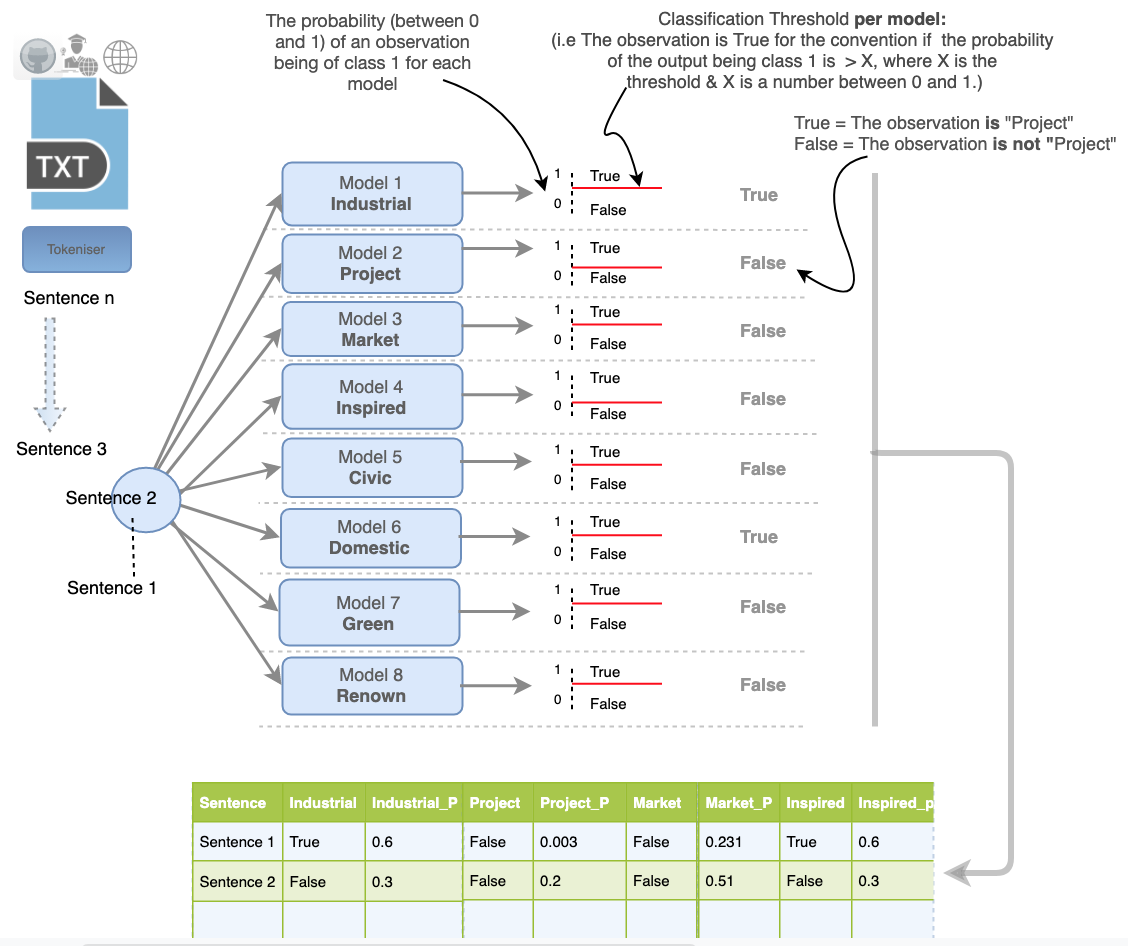

In [3]:
url = 'https://github.com/aideenf/AIVC/raw/master/cp_wssc/Drawings/models.png'
r = req.get(url)
display (PIL_Img.open(BytesIO(r.content)))

In [4]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;}

<IPython.core.display.Javascript object>

# Global Variables

In [5]:

_DLModelsIsotonicRegression = {}
_DLModels = {}
_DLData_val_x_txt_seq = {}
_DLData_val_x_txt = {}
_DLData_val_y = {}
training_val_df = pd.DataFrame()

gathered_conventions_files = {} 
gathered_conventions_df = pd.DataFrame()


labelled_data_df = pd.DataFrame()
training_val_data = pd.DataFrame()
calibration_df = pd.DataFrame()
test_df = pd.DataFrame()


metrics_for_all = pd.DataFrame()

global_final_threshold = {}
global_final_results_df = pd.DataFrame()

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Methods used at various steps

In [37]:
 # #move to model helpers
def get_positive_preds_with_threshold(preds, threshold=0.5):
    #Keras .predict returns a list of [x, y] values where x = probability of 0 and y is probability of 1
    #ie 
    preds_results = []
    for j in range(len(preds)):
        #int_pred = int(preds[j][1]>=threshold)
        int_pred = int(preds[j]>=threshold)
        preds_results.append(int_pred)
    return preds_results

def get_positive_preds_probabilities(preds):
    #Keras .predict returns a list of [x, y] values where x = probability of 0 and y is probability of 1
    #i.e preds[j][1] is the probability of a positive prediction.
    preds_results = []
    for j in range(len(preds)):
        int_pred = preds[j][1]
        preds_results.append(int_pred)    
    return preds_results

def apply_pred_threshold(preds, t):
    res = np.zeros(len(preds))  
    res[preds>=t] = 1
    return res
 # #move to model helpers
    
    

def calculate_metrics(results, num_samples, model):
    
    results.insert(0,'index', range(0,results.shape[0]))
    metrics_df = pd.DataFrame(index = results['index'], columns=['model','threshold','accuracy', 'precision_ppv', 'recall_sensitivity_tpr', 'f1', 'f2', 'f0_5','specifity_selectivity_tnr', 'tpr', 'fpr'])

    for i in results.iterrows():
        
        index, threshold, tp, fp, tn, fn = i[1]

        assert tp + fp + tn + fn == num_samples 
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
            f2 = 0
            f0_5 = 0
            
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f2 = (2*2 + 1)*precision*recall / (2*2*precision + recall)#weights recall higher than precision, and 
            f0_5  = (.5*.5 + 1)*precision*recall /(.5*.5*precision + recall)#puts more emphasis on precision than recall.

        
        false_positive_rate = fp / (fp + tn)
        
        accuracy = (tp+tn)/(tp + fp + tn + fn)
        specifity = tn / (tn + fp)
        
        metrics_df.loc[index, 'model'] = model
        metrics_df.loc[index, 'accuracy'] = accuracy
        metrics_df.loc[index, 'precision_ppv'] = precision
        metrics_df.loc[index, 'recall_sensitivity_tpr'] = recall
        metrics_df.loc[index, 'f1'] = f1
        metrics_df.loc[index, 'f2'] = f2
        metrics_df.loc[index, 'f0_5'] = f0_5
        metrics_df.loc[index, 'specifity_selectivity_tnr'] = specifity
        metrics_df.loc[index, 'tpr'] = true_positive_rate
        metrics_df.loc[index, 'fpr'] = false_positive_rate  #inverse recall    
    metrics_df.reset_index()
    metrics_df = pd.concat([results, metrics_df.drop("threshold", axis=1)],axis=1, join='inner', sort = False)
    metrics_df = metrics_df.drop("index", axis=1)
    
    #set the model name to col 0 for consistency
    model = metrics_df.pop('model')
    metrics_df.insert(0, 'model', model)
    return metrics_df


def calculate_full_set_micro_average(results):
    
    metrics_df = pd.DataFrame(columns=['model','threshold','tp', 'fp', 'tn', 'fn', 'accuracy', 'precision_ppv', 'recall_sensitivity_tpr', 'f1', 'f2', 'f0_5','specifity_selectivity_tnr', 'tpr', 'fpr'])    
    tp =  results[0]
    fp =  results[1]
    tn =  results[2]
    fn =  results[3]
  
    recall = tp / (tp + fn)
        
    if tp == fp == 0:
        precision = 0
        true_positive_rate = 0
        
    else:
        precision = tp / (tp + fp)
        true_positive_rate = tp / (tp + fn)
            
    if precision == recall == 0:
        f1 = 0
        f2 = 0
        f0_5 = 0
            
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        f2 = (2*2 + 1)*precision*recall / (2*2*precision + recall)#weights recall higher than precision, and 
        f0_5  = (.5*.5 + 1)*precision*recall /(.5*.5*precision + recall)#puts more emphasis on precision than recall.

        
    false_positive_rate = fp / (fp + tn)
        
    accuracy = (tp+tn)/(tp + fp + tn + fn)
    specifity = tn / (tn + fp)
    

    metrics_df.loc[0, 'model'] = "set_micro_average"
    metrics_df.loc[0, 'threshold'] = "NaN"
    metrics_df.loc[0, 'tp'] = tp
    metrics_df.loc[0, 'fp'] = fp
    metrics_df.loc[0, 'tn'] = tn
    metrics_df.loc[0, 'fn'] = fn
    metrics_df.loc[0, 'accuracy'] = accuracy
    metrics_df.loc[0, 'precision_ppv'] = precision
    metrics_df.loc[0, 'recall_sensitivity_tpr'] = recall
    metrics_df.loc[0, 'f1'] = f1
    metrics_df.loc[0, 'f2'] = f2
    metrics_df.loc[0, 'f0_5'] = f0_5
    metrics_df.loc[0, 'specifity_selectivity_tnr'] = specifity
    metrics_df.loc[0, 'tpr'] = true_positive_rate
    metrics_df.loc[0, 'fpr'] = false_positive_rate  #inverse recall    
    metrics_df.reset_index()
   
    
    #set the model name to col 0 for consistency
    model = metrics_df.pop('model')
    metrics_df.insert(0, 'model', model)
    
    return metrics_df




def display_data(df_in):
    display(HTML("Data Analysis, number of sentences per convention"))

    df = pd.DataFrame(df_in.groupby(['convention','label'])['text'].count())
    df = df.reset_index()
    df = df.rename(columns={"text": "count"})
    df_0 = df[df.label == 0].copy()
    df_1 = df[df.label == 1].copy()
    df = df_1
    if (df_0.shape[0] > 0):
        df['label 0 count'] = list(df_0['count'])
    df = df.rename(columns={"count": "label 1 count"}).drop(['label'], axis = 1)
    table = ff.create_table(df)
    iplot(table, filename='count')
    
    counts_cross_tab = pd.crosstab(df_in['label'],df_in['convention'])
    
    fig = plt.figure(figsize=(16,7))
    axes1 = plt.subplot(1,2,1)
    counts_cross_tab.plot(ax = axes1, kind='bar', title ="Data Count")
  
    axes2 = plt.subplot(1,2,2)
    axes2 = model_helpers.label_cardinality_bar(df.drop("convention", axis=1).drop("label", axis=1).drop("text", axis=1)) 
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()
    gc.collect()
    
    
    
#split the labelled data so that a specified fraction(from a specified provenance) is returned in seperate dataframes
def split_data(df, cut_b = .2, provenance_b=[]):
    
    data_a = pd.DataFrame() #dataframe to be returned with 1 - cut_b %
    data_b = pd.DataFrame() #dataframe to be returned with cut_b %
    print ("cut size:",cut_b)
    
#     df = df.sample(frac=1) #change the order of the rows to random order
    
    df = df.reset_index(drop=True)
    print(df.shape[0], "Note: this can contain multi-label samples, and samples with no convention")
    
    df['unique_id'] = df.index
    
    data_a  = df.copy()
    #will be used to create the data_b which will only contain data from provenance specified
    df_to_cut_from = df[df.provenance.isin(provenance_b)].copy()
    
    #obtaining a count of positive samples per convention and store in dataframe to create dict
    count = df.drop(['text', 'provenance', 'unique_id'], axis = 1).sum(axis='rows')
    cuts_conv = {}
    #iterate through the df with count per convention to determine the split per convention. 
    for conv, x in zip ( list(count.index.values), range(len(list(count.index.values)))):
        cuts_conv[conv] =  int(count.iloc[x]*cut_b)     
    #display("Number of samples needed per convention to create the specified %split:", cuts_conv)
    
    #obtaining a count of positive samples per convention (with restricted provenance) and store in dataframe to create dict
    count = df_to_cut_from.drop(['text', 'provenance', 'unique_id'], axis = 1).sum(axis='rows')
    conv_avail = {}
    for conv, x in zip ( list(count.index.values), range(len(list(count.index.values)))):
        conv_avail [conv] =  int(count.iloc[x])    
    #display("Total number of samples available per convention(restricted to provenance specified for data_b):)", conv_avail)
    
    
    def unique(list1): 
        x = np.array(list1) 
        return list(np.unique(x)) 
    
    unique_id_list = []
    
    temp_df = pd.DataFrame()
    
    #for every convention
    for conv in cuts_conv:
        print ("")
        print ("convention", conv)
        print ("Samples needed according to %value:", cuts_conv[conv])
        print ("Samples available when some provenances are not used:", conv_avail[conv])
        #the number of samples to use in data_b is either the %needed or the total available, whichever is smaller
        cut = min (cuts_conv[conv], conv_avail[conv]) 
        #print ("No of Samples we will use for data_b is minimum of above, ie :",cut)
        
        #now create a data_frame containing "cut" number of samples for convention in question
        temp_df = df_to_cut_from[df_to_cut_from[conv] == 1].sample(n = cut)
        #Record the unique id so that we can remove this sample from data_a before returning data_a
        unique_id_list.extend(list(temp_df['unique_id'].values))
        data_b = pd.concat([data_b, temp_df])
     
    data_a = data_a.drop(unique(unique_id_list)) 
    #print("")
    #print("Number of samples in original multi-label input:", df.shape[0])
    #print ("Number of samples required for data_b:", df.shape[0]*cut_b)
    print ("Number of samples in data_b:", data_b.shape[0])
    print ("Number of samples in data_a:", data_a.shape[0])
    print ("Total in data_a + data_b", data_a.shape[0] + data_b.shape[0])
    
    
    
    data_a = data_a.drop_duplicates(keep = "first").drop('unique_id', axis = 1).reset_index(drop=True)
    data_b = data_b.drop_duplicates(keep = "first").drop('unique_id', axis = 1).reset_index(drop=True)
    agg_funct = {
        'civic':'max', 
        'domestic':'max',
        'green':'max',
        'industrial':'max',
        'inspired':'max',
        'market':'max',
        'project':'max',
        'renown':'max',
        'text':'first',
        'provenance':'first'
        }

    data_a = pd.DataFrame(data_a.groupby(data_a['text']).aggregate(agg_funct))
    data_a  = data_a.drop("text", axis = 1).reset_index()
    
    
    data_b = pd.DataFrame(data_b.groupby(data_b['text']).aggregate(agg_funct))
    data_b  = data_b.drop("text", axis = 1).reset_index()
    
    return data_a, data_b





def get_X_y_from_pd(df, convention):
    # sequence, for df['convention'] == convention
    data_x_1 = df.loc[df[convention]== 1, 'sequence']
    data_x_0 = df.loc[df[convention]== 0, 'sequence']
    
    # sequence is stored as a string so here we convert it back.
    data_x = []
    data_x_1 = list(data_x_1)
    data_x_0 = list(data_x_0)
    for seq, index in zip(data_x_1, range(len(data_x_1))):
        data_x.append(data_x_1[index])
        #data_x.append(list(map(int, data_x_1[index].replace('[', '').replace(']', '').split(','))))

    for seq, index in zip(data_x_0, range(len(data_x_0))):
        data_x.append(data_x_0[index])
        #data_x.append(list(map(int, data_x_0[index].replace('[', '').replace(']', '').split(','))))
    print ("All sentences", len(data_x))
    print (convention, "sentences", len(data_x_1))
    
    data_x = np.asarray((data_x))

    y_actual = []
    y_actual_1 = df.loc[df[convention]== 1, convention]
    y_actual_0 = df.loc[df[convention]== 0, convention]
    for y in y_actual_1:
        y_actual.append(y)
    #print ("only sentences true for",convention,len(data_x))
    for y in y_actual_0:
        y_actual.append(y)
    #print ("All sentences", len(data_x))
    return data_x, y_actual



#  tokenizes the 'text' field in a dataframe and adds to new column "sequence"
def get_txt_seq(df, _tokenizer, seq_len):

    extended_tokenizer = _tokenizer
        
    sequences = extended_tokenizer.texts_to_sequences(df['text'])
    data = pad_sequences(sequences, maxlen= seq_len) 
    extended_tokenizer = 0
    df['sequence'] = list(data)
    sequences = 0
    return df
    gc.collect()



def update_predict_info(df):
    y_pred_list = []
    prob_list = []
    conv_list = []
    
    for conv in _DLModels.keys():
        conv_list.append(conv)
        y_pred_list.append(conv+'_y_pred')
        prob_list.append(conv+'_prob')
        
    #add the label cardinality as the sum of all the predicted = 1 for sentence for conventions
    pred_sums = df[y_pred_list].sum(axis=1)
    df['lbl_cnt'] = pred_sums
    
    #add the overall score as the product of all the individual predicted convention scores
    prob_product= df[prob_list].prod(axis=1)
    df['set_conf'] = prob_product
    
    
    #this will be > 1 if the same sentence was used as True for 2 or more conventions.
    positive_sample = df[conv_list].sum(axis=1)
    df['pos_sample'] = positive_sample
    return df


def aggregate_new_audited_files(audited_data_dir_git, github_audit_url, git_owner_repo, git_owner, git_repo, aivm_helper):
    #Read the data that has been audited using the new format, from paths.GITHUB_AUDIT_URL_PATH, the format is
    # "audited_labelled_data_" + user + dat _.tsv
    
    my_file_list = aivm_helper.list_files_from_github_dir(git_owner, git_repo, audited_data_dir_git)
    # Helper file call to Remove our standard excluded files and all files that are not "audited_training_data"
   
    my_file_list = aivm_helper.remove_excluded_files_except(my_file_list, "audited_labelled_data_")
    
    if (len(my_file_list) > 0):
        # Returns a dataframe of concatinated files from github, of names from file_list from the github url specified.
        audited_df = aivm_helper.concat_files_from_github_dir(github_audit_url, my_file_list)
        #this is already done for 
        audited_df['text'] = audited_df['text'].str.strip()
        audited_df['text'] = audited_df['text'].apply(aivm_helper.pre_process_sentence)
        
        return audited_df.reset_index(drop=True)
    

# Read the Labeled data and also the gathered data(to generate vocab for word embedding)

## Read Labelled data 

In [25]:
#Read the combined original training data and the original single-lable audited data from "training_ALL.tsv"
#Format is as below.
#text	provenance	civic	domestic	green	industrial	inspired	market	project	renown
original_labelled_data_df = model_helpers.get_labelled_data(
                            USE_GIT_HUB,
                            paths.LABELLED_DATA_ALL_DIR_FILE_GIT,
                            paths.LABELLED_DATA_ALL_DIR_FILE_LOCAL, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

#Read the data that has been audited using the new format, from paths.GITHUB_AUDIT_URL_PATH, the format is
# "audited_labelled_data_" + user + dat _.tsv
audited_labelled_data_df = aggregate_new_audited_files (paths.AUDITED_DATA_DIR_GIT,
                            paths.GITHUB_AUDIT_URL_PATH, 
                            paths.GIT_OWNER_REPO,
                            paths.GIT_OWNER,
                            paths.GIT_REPO,
                            aivm_helper)       




Initialised generic_parsing_helpers class and methods


In [27]:
print (paths.LABELLED_DATA_ALL_DIR_FILE_GIT)

display (audited_labelled_data_df.head(5))


# If we've still got a chance it seems to lay in open revolution against the last of our powers to shape our own society being turned over to algorithms

https://raw.githubusercontent.com/aideenf/AIVC/master/cp_wssc/Data/Iterative-models-building/Labelled_data/Conventions/labelled_ALL.tsv


,text,provenance,civic,domestic,green,industrial,inspired,market,project,renown
0,In this study we investigate the global exponential stability of inertial memristor based neural networks with impulses and time varying delays.,s2_ai,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,The sensor is based on a novel modular version of a three dimensional printed tactile sensor (TacTip).,s2_ai,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Consequently wind exerts a major influence on the overall dynamics of an MAV.,s2_ai,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Our experiments demonstrate that this approach is effective in inpainting facial components such as the mouth or the eyes that could be partially or completely occluded in the input face.,s2_ai,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,Thus the weight belt because of its simplicity must be further considered as a more convenient candidate to translate the results of TPAD in children with cerebral palsy who suffer from crouch gait.,s2_ai,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:
labelled_data_df = pd.concat([original_labelled_data_df, audited_labelled_data_df])
#Remove duplicated labelled data
labelled_data_df = labelled_data_df.drop_duplicates(keep = "first")
agg_funct = {
        'civic':'max', 
        'domestic':'max',
        'green':'max',
        'industrial':'max',
        'inspired':'max',
        'market':'max',
        'project':'max',
        'renown':'max',
        'text':'first',
        'provenance':'first'
        }

labelled_data_df = pd.DataFrame(labelled_data_df.groupby(labelled_data_df['text']).aggregate(agg_funct))
labelled_data_df  = labelled_data_df.drop("text", axis = 1).reset_index()
print ("Num dupes = ", labelled_data_df.shape[0] - len(labelled_data_df.text.unique()))
print ("Total count = ", len(labelled_data_df.text.unique()))
display (labelled_data_df.tail(20))
# display (labelled_data_df.iloc[0][0])



Num dupes =  0
Total count =  3634


,text,civic,domestic,green,industrial,inspired,market,project,renown,provenance
3614,you forgot bicentineal man it has robin Williams in it playing the main character.i think you should see it.,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,reddit_ai
3615,you get the idea I’ve always wondered though in most cases your customers aren’t giving you labelled data.,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,reddit_ai
3616,you should understand this context in order to manage the system performance efficiently.,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Manually_gathered
3617,you trust your users and want to avoid the extra verification step.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Manually_gathered
3618,you want compiled control flow use structured control flow primitives like,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Manually_gathered
3619,you will only have to pay amazon for using their storage.,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Manually_gathered
3620,you're just looking for some inspirationinspiration we've got you covered.,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Manually_gathered
3621,your data are still on s servers so you pay $. for those two gigabytes but not a single cent will be charged for any transfer.,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Manually_gathered
3622,your preferred price and performance.,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Manually_gathered
3623,yourself or pay someone to do it if you think it's worth the effort.,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Manually_gathered


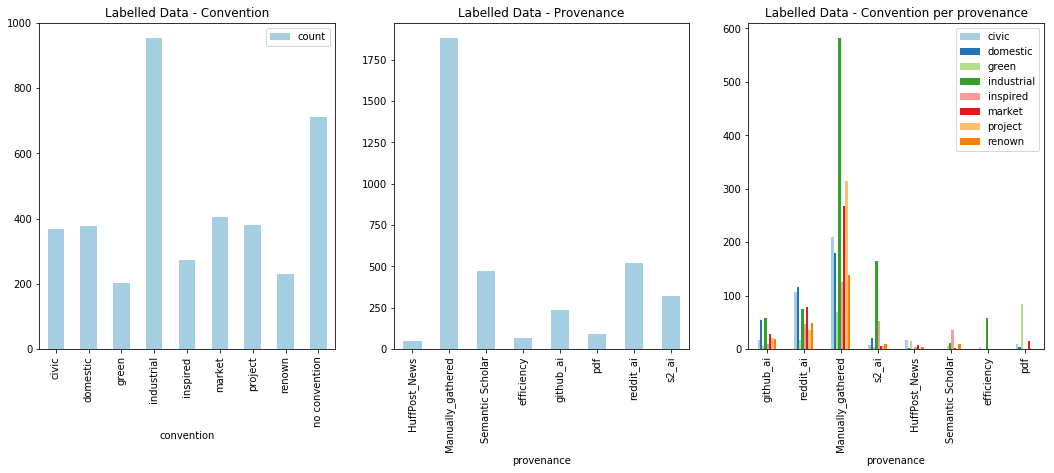

commit GitCommit(sha="d8a4480a91889dd13d0ccf577910c8d8aab18532")
File to commit: ['Data/Iterative-models-building/Resources/labelled_data_proportions.png']
Push to git as: ['cp_wssc/Data/Iterative-models-building/Resources/labelled_data_proportions.png']
Commit:  GitCommit(sha="d8a4480a91889dd13d0ccf577910c8d8aab18532")


               count
convention          
civic          369.0
domestic       377.0
green          201.0
industrial     952.0
inspired       273.0
market         406.0
project        379.0
renown         231.0
no convention  712.0


<Figure size 432x288 with 0 Axes>

In [31]:
def display_labelled_data(df, text, save_graph):
    provenance_count = pd.DataFrame()
    temp = pd.DataFrame()
    provenance_count ['provenance'] = df['provenance'].unique()
    temp['provenance'] = df['provenance'].unique().sort()
    
    convention_count = df.drop(['text', 'provenance'], axis = 1).sum(axis='rows').reset_index()
    
    no_convention =  df[ (df.civic == 0) & 
                    (df.domestic == 0) & 
                    (df.green == 0) & 
                    (df.industrial == 0) & 
                    (df.inspired == 0) & 
                    (df.market == 0) & 
                    (df.project == 0) & 
                    (df.renown == 0)]
    
    convention_count = convention_count.append({'index': "no convention", 0:no_convention.shape[0]}, ignore_index=True)
    
    convention_count = convention_count.rename(columns={0: "count", "index": "convention"})
    convention_count = convention_count.set_index("convention")
    convention_list = list(df.drop(['text', 'provenance'], axis = 1).columns)
    
    for conv in convention_list:
        temp = df.groupby(['provenance',conv])['text'].count().reset_index()
        temp = temp[temp[conv] == 1]
        temp = temp.drop(conv, axis = 1)
        temp = temp.rename(columns = {'text':conv} ) 
        provenance_count = pd.merge(provenance_count, temp, on = 'provenance', how = 'outer')
        provenance_count = provenance_count.fillna(0).set_index('provenance')

   


    fig = plt.figure(figsize=(18,6))
    ax1 = plt.subplot(1,3,1)
    ax2 = plt.subplot(1,3,2)
    ax3 = plt.subplot(1,3,3)
    ax3.ylabel = df['provenance'].unique()
    convention_count.plot(kind='bar', title =text+" - Convention",ax=ax1)
#     df.drop(['text', 'provenance'], axis = 1).sum(axis='rows').plot(kind='bar', title =text+"- Convention",ax=ax1)
    df.groupby('provenance')['text'].count().plot(kind='bar', title =text+" - Provenance", ax=ax2)
    provenance_count.plot(kind='bar' ,title =text+" - Convention per provenance", ax=ax3)
    
    plt.show()
    if save_graph == True:
        fig = aivm_helper.save_plot(ax3,
                                        "labelled_data_proportions.png", 
                                         paths.RESOURCES_DIR_LOCAL, 
                                         paths.RESOURCES_DIR_GIT, 
                                         USE_GIT_HUB, 
                                         GIT_USR, 
                                         GIT_PSWD, 
                                         paths.GIT_OWNER_REPO)                       

    plt.clf()
    gc.collect()
    print (convention_count)

        
display_labelled_data(labelled_data_df, "Labelled Data", True)

## Read "Gathered" data 

Initialised AIVM_helper class and methods


,provenance,text
0,HuffPost_News,2676
1,Semantic Scholar,16169
2,efficiency,434
3,github,134365
4,pdf_green,763
5,reddit,38404


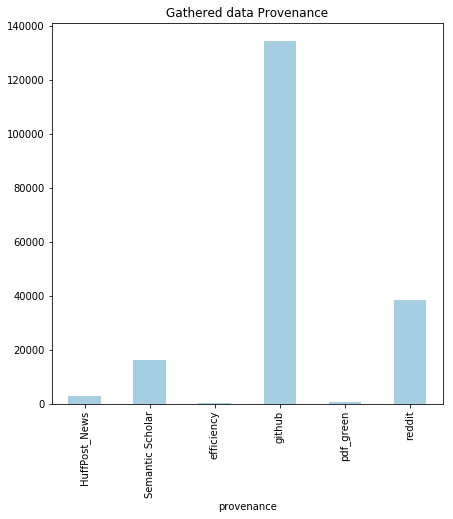

Total number of sentences: 192820


<Figure size 432x288 with 0 Axes>

In [32]:
#Note this method already processes the gathered data and reads either from local or directly from git.
gathered_data_files, gathered_data_df = model_helpers.get_aggregated_gathered_data (
                            USE_GIT_HUB,
                            paths.GATHERED_DATA_CONV_DIR_GIT,
                            paths.GATHERED_DATA_CONV_DIR_LOCAL,
                            paths.GITHUB_GATHERED_URL_PATH, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)



def display_gathered_data(df):
    df['text'] = df['text'].str.strip()
    df['text'] = df['text'].apply(aivm_helper.pre_process_sentence)
    display(HTML("Gathered data"))
    count = pd.DataFrame(df.groupby('provenance')['text'].count() ).reset_index()
    display (count)

    fig = plt.figure(figsize=(8,8))
    df.groupby('provenance')['text'].count().plot(kind='bar', figsize=(7,7), title ="Gathered data Provenance")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()
    print ("Total number of sentences:",df.shape[0] )

display_gathered_data(gathered_data_df)

# Get a list of keywords per convention from the Labelled data

In [33]:
#test = labelled_data_df[labelled_data_df['text'].str.contains("<")]
#print (test["text"])

#Set show = True to see a print of the top 30(also stored in all_words df)
all_words, top_5 = model_helpers.get_keyword_list(labelled_data_df, 0.05, 30, show=False)
display(top_5)


all_words.to_csv(paths.RESOURCES_DIR_LOCAL + 'keywords_df.csv', index = False)

if USE_GIT_HUB == True:
    my_file_list = [paths.RESOURCES_DIR_LOCAL + 'keywords_df.csv']
    push_to_git_as = [paths.RESOURCES_DIR_GIT + 'keywords_df.csv']
    
    commit, message = aivm_helper.save_to_github(GIT_USR, GIT_PSWD, paths.GIT_OWNER_REPO, my_file_list, push_to_git_as, "auto save keywords")

    if (commit != "error"):
        print ("File to commit:", my_file_list)
        print ("Push to git as:", push_to_git_as)
        print ("Commit: ", commit)
        display(HTML("<font color='green'><b>Keywords Saved to GIT Resource folder!!</b></font>"))
        
            
    if (commit == "error"):
        print ("File to commit: ", my_file_list)
        print ("Push to git as: ", push_to_git_as)
        display(HTML("<font color='red'><b>Warning!!</b></font>"))
        print(message)


del all_words

gc.collect()

,Convention,Keywords
0,Civic,"Collective, Civic, Interests, Solidarity, Tensorflow"
1,Domestic,"Superiors, Upbringing, Household, Trust, Children"
2,Green,"Green, Economy, Carbon, Growth, Low"
3,Industrial,"Performance, Standard, Tests, Learning, Reliable"
4,Inspired,"Inspiration, Inspired, Passion, Images, Visual"
5,Market,"Customized, Goods, License, Sell, Buy"
6,Project,"City, Projective, Connections, Links, Networks"
7,Renown,"Opinion, Press, Fame, Audience, Famous"


commit GitCommit(sha="679acb4576cb5a0581eaa9e6d823c12b9590f300")
File to commit: ['Data/Iterative-models-building/Resources/keywords_df.csv']
Push to git as: ['cp_wssc/Data/Iterative-models-building/Resources/keywords_df.csv']
Commit:  GitCommit(sha="679acb4576cb5a0581eaa9e6d823c12b9590f300")


2744

# Extract the Training/Validation data from the Labelled data

In [34]:
display(labelled_data_df.provenance.unique())

array(['github_ai', 'reddit_ai', 'Manually_gathered', 's2_ai',
       'HuffPost_News', 'Semantic Scholar', 'efficiency', 'pdf'],
      dtype=object)

cut size: 0.3
3634 Note: this can contain multi-label samples, and samples with no convention

convention civic
Samples needed according to %value: 110
Samples available when some provenances are not used: 340

convention domestic
Samples needed according to %value: 113
Samples available when some provenances are not used: 372

convention green
Samples needed according to %value: 60
Samples available when some provenances are not used: 101

convention industrial
Samples needed according to %value: 285
Samples available when some provenances are not used: 892

convention inspired
Samples needed according to %value: 81
Samples available when some provenances are not used: 269

convention market
Samples needed according to %value: 121
Samples available when some provenances are not used: 383

convention project
Samples needed according to %value: 113
Samples available when some provenances are not used: 376

convention renown
Samples needed according to %value: 69
Samples available when s

,civic,domestic,green,industrial,inspired,market,project,renown
0.0,2476,2465,2572,2069,2528,2436,2452,2552
1.0,234,245,138,641,181,273,257,157


Number of samples negative for all conventions:  712
Number of negative needed to balance  civic 234
Number of samples negative for all conventions:  712
Number of negative needed to balance  domestic 245
Number of samples negative for all conventions:  712
Number of negative needed to balance  green 138
Number of samples negative for all conventions:  712
Number of negative needed to balance  industrial 641
Number of samples negative for all conventions:  712
Number of negative needed to balance  inspired 181
Number of samples negative for all conventions:  712
Number of negative needed to balance  market 273
Number of samples negative for all conventions:  712
Number of negative needed to balance  project 257
Number of samples negative for all conventions:  712
Number of negative needed to balance  renown 157


convention,civic,domestic,green,industrial,inspired,market,project,renown
0,233,244,137,640,180,272,256,156
1,234,245,138,641,181,273,257,157


convention,provenance,civic,domestic,green,industrial,inspired,market,project,renown
0,HuffPost_News,17,6,16,18,8,10,6,5
1,Manually_gathered,219,211,76,607,159,258,293,146
2,Semantic Scholar,61,70,54,206,73,79,81,55
3,efficiency,6,9,3,62,6,5,4,3
4,github_ai,24,53,10,82,18,41,26,24
5,pdf,16,12,84,20,3,20,9,3
6,reddit_ai,95,98,21,126,51,100,60,50
7,s2_ai,29,30,11,160,43,32,34,27


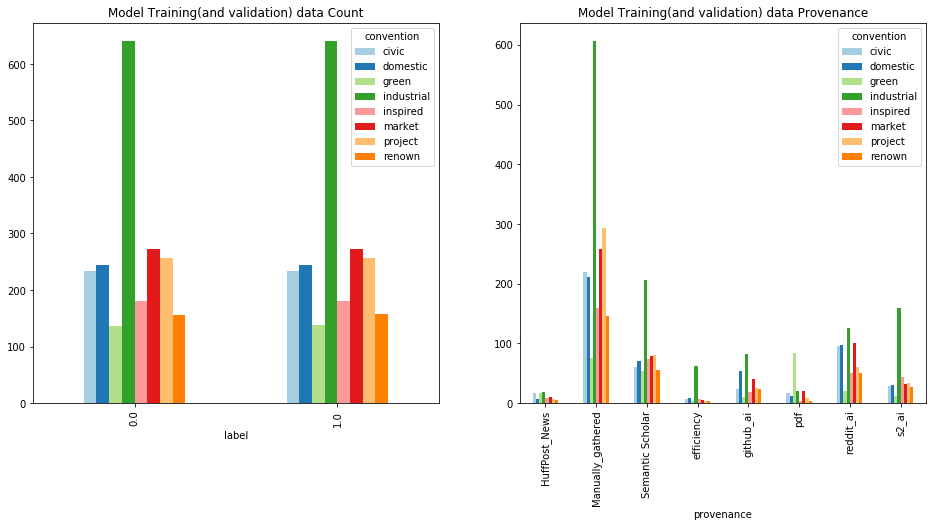

<Figure size 432x288 with 0 Axes>

In [39]:
def display_training_val_data (df):
   
    counts_cross_tab = pd.crosstab(df['label'],df['convention'])
    provenance_cross_tab = pd.crosstab(df['provenance'],df['convention'])
  
    display(counts_cross_tab.reset_index(drop=True))
    display(provenance_cross_tab.reset_index())
    fig = plt.figure(figsize=(16,7))
    axes1 = plt.subplot(1,2,1)
    axes2 = plt.subplot(1,2,2)
    counts_cross_tab.plot(ax = axes1, kind='bar', title ="Model Training(and validation) data Count")
    provenance_cross_tab.plot(ax = axes2, kind='bar', title ="Model Training(and validation) data Provenance")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()

    provenance_cross_tab = pd.DataFrame()
    gc.collect()



#keep 40%(per convention) of the labelled data for calibration and testing.
#the calibration split will be split further later
provenance_b = ['Manually_gathered', 'Semantic Scholar', 's2_ai' ,'github_ai' ,'reddit_ai' ]
#split the labelled data and returns df_a and df_b, so that a specified fraction(from a specified provenance) is returned in df_b
training_val_df, calibration_test_df = split_data(labelled_data_df, cut_b = .3, provenance_b = provenance_b)

print("training_val_df: " , training_val_df.provenance.unique())
print("calibration_test_df: ", calibration_test_df.provenance.unique())

training_val_df, cross_tab = model_helpers.create_label_balance(training_val_df)
display_training_val_data (training_val_df)


In [41]:
display("Training the models", training_val_df.provenance.unique())
display("For Calibration and test",calibration_test_df.provenance.unique())
pd.set_option('display.max_colwidth', -1)
training_val_df.head(20)

'Training the models'

array(['reddit_ai', 'github_ai', 'Manually_gathered', 'HuffPost_News',
       'efficiency', 's2_ai', 'pdf', 'Semantic Scholar'], dtype=object)

'For Calibration and test'

array(['github_ai', 'reddit_ai', 'Manually_gathered', 's2_ai',
       'Semantic Scholar'], dtype=object)

,label,text,provenance,convention
0,1.0,'Sirius' Is the Google Backed Open Source Siri.,reddit_ai,civic
1,1.0,(.Abs) ​ Abstract Machines powered by artificial intelligence increasingly mediate our social cultural economic and political interactions.,reddit_ai,civic
2,1.0,.. pypi resources tensorflow.org tensorflow tutorials tensorflow official models tensorflow examples tensorflow in practice from coursera tensorflow blog tensorflow twitter tensorflow youtube tensorflow roadmap tensorflow white papers tensorboard visualization toolkit more about the tensorflow community and how to contribute license apache license.(license) '.,github_ai,civic
3,1.0,A Reddit like community that uses Text Summarization for news.,reddit_ai,civic
4,1.0,A valid concern.,reddit_ai,civic
5,1.0,Additionally you can modify SAM to integrate it with other frameworks and deployment providers from the community for building serverless applications.,Manually_gathered,civic
6,1.0,After 'Black Panther ' Will Hollywood Finally Admit That Black Films Can Travel?The worldwide success of the Marvel film calls into question how we think of black led films and markets abroad.,HuffPost_News,civic
7,1.0,Amid the sea of fear and propaganda this is hardly mentioned as a possibility but is a more realistic one : Strong Ai will likely result in a more fair equal and harmonized society.,reddit_ai,civic
8,1.0,Anxiety Provoking Situations And How To DealAndy Puddicombe is a former Buddhist monk and the founder of Headspace a project to make meditation accessible to busy people,HuffPost_News,civic
9,1.0,Apple Google and Netflix don't require employees to have year degrees and this could soon become an industry norm.,reddit_ai,civic


# Train the DL Models
A multi-label classifier assigns a set of labels to each sentence. The simplest multi-label classifier, called Binary Relevance (BR), applies one binary classifier to each label(convention) independently and takes the product of the individual label probabilities as the overall label-set probability (confidence). Despite its many known drawbacks, such as generating suboptimal predictions and poorly calibrated confidence scores, BR is widely used in practice due to its speed and simplicity.[ Tsoumakas, G., Katakis, I.: Multi-label classification: An overview. Int J Data Warehousing and Mining 2007, 1–13 (2007)]

As this problem is multi-label and multi class the overall solution is a one v's all, Binary Relevance approach.

In [42]:
## Train DL models
## Vocabulary loading
def _read_glove_embeddings(glove_dir, embedding_dim):
    print ("Reading word embedding from:", os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
    ## Reading GLOVE (precalculated word embeddings)
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index



def train_models(gathered_df, training_df):
    print ("training")
    display (training_df.head())
    print ("gathered")
    display (gathered_df.head())
    embeddings_index =_read_glove_embeddings(glove_dir=paths.GLOVE_DIR_LOCAL, embedding_dim=model_helpers.EMBEDDING_DIM)
    print ("Embeddings:", type(embeddings_index))
    column_to_tokenize = 'text'
    

    gathered_and_training = pd.DataFrame(gathered_df[column_to_tokenize].append(training_df[column_to_tokenize]))##Adding training data sentences
    extended_tokenizer = parsing_helpers.create_tokenizer(gathered_and_training, 
                                                            column_to_tokenize,
                                                          max_words=model_helpers.MAX_NB_WORDS)

        
    
    print ("Tokenizer:", type(extended_tokenizer))

    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_x_txt, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models(
                    training_df,
                    embeddings_index,                                                                                                             
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=False
                    ) 

    
    
    gc.collect()
    return _DLModels, extended_tokenizer


_DLModels, extended_tokenizer = train_models(gathered_data_df, training_val_df)



training


,label,text,provenance,convention
0,1.0,'Sirius' Is the Google Backed Open Source Siri.,reddit_ai,civic
1,1.0,(.Abs) ​ Abstract Machines powered by artificial intelligence increasingly mediate our social cultural economic and political interactions.,reddit_ai,civic
2,1.0,.. pypi resources tensorflow.org tensorflow tutorials tensorflow official models tensorflow examples tensorflow in practice from coursera tensorflow blog tensorflow twitter tensorflow youtube tensorflow roadmap tensorflow white papers tensorboard visualization toolkit more about the tensorflow community and how to contribute license apache license.(license) '.,github_ai,civic
3,1.0,A Reddit like community that uses Text Summarization for news.,reddit_ai,civic
4,1.0,A valid concern.,reddit_ai,civic


gathered


,text,provenance
0,Tensorflow is an end to end open source platform for machine learning.,github
1,It has a comprehensive flexible ecosystem of tools and community resources that lets researchers push the state of the art in ml and developers easily build and deploy ml powered applications.,github
2,Tensorflow was originally developed by researchers and engineers working on the google brain team within google's machine intelligence research organization for the purposes of conducting machine learning and deep neural networks research.,github
3,The system is general enough to be applicable in a wide variety of other domains as well.,github
4,Tensorflow provides stable python c apis as well as non guaranteed backwards compatible api for other languages up to date with release announcements and security updates by subscribing to announce@tensorflow.org forum announce).,github


Reading word embedding from: Data/Iterative-models-building/Training data/glove.6B.100d.txt
Embeddings: <class 'dict'>
Tokenizer: <class 'keras_preprocessing.text.Tokenizer'>
Found 106111 unique tokens.
----------------------------------------------------------------
            civic                  
----------------------------------------------------------------
Shape of data tensor: (467, 32)
Shape of label tensor: (467, 2)

Number of elements from each class in traing and validation set 
[233. 234.]


/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning:

Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning:

Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning:

Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`



model fitting - more complex convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 100)      10611200    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 128)      38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 29, 128)      51328       embedding_1[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning:

Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning:

Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning:

Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`



model fitting - more complex convolutional neural network
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 100)      10611200    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 30, 128)      38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 29, 128)      51328       embedding_2[0][0]                
__________________________________

dense_5 (Dense)                 (None, 128)          32896       flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            258         dense_5[0][0]                    
Total params: 10,880,386
Trainable params: 269,186
Non-trainable params: 10,611,200
__________________________________________________________________________________________________
Epoch 1/20
275/275 [==============================] - 1s 2ms/step - loss: 1.4588 - acc: 0.5055
Epoch 2/20
275/275 [==============================] - 1s 2ms/step - loss: 0.5997 - acc: 0.6400
Epoch 3/20
275/275 [==============================] - 1s 2ms/step - loss: 0.7495 - acc: 0.5855
Epoch 4/20
275/275 [==============================] - 1s 2ms/step - loss: 0.4788 - acc: 0.8109
Epoch 5/20
275/275 [==============================] - 1s 2ms/step - loss: 0.4427 - acc: 0.8364
Epoch 6/20
275/275 [=========================

1281/1281 [==============================] - 2s 2ms/step - loss: 0.1368 - acc: 0.9719
Epoch 20/20
1281/1281 [==============================] - 2s 2ms/step - loss: 0.0022 - acc: 1.0000




----------------------------------------------------------------
            inspired                  
----------------------------------------------------------------
Shape of data tensor: (361, 32)
Shape of label tensor: (361, 2)

Number of elements from each class in traing and validation set 
[180. 181.]
model fitting - more complex convolutional neural network
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)       

Total params: 10,880,386
Trainable params: 269,186
Non-trainable params: 10,611,200
__________________________________________________________________________________________________
Epoch 1/20
545/545 [==============================] - 1s 2ms/step - loss: 1.0916 - acc: 0.5156
Epoch 2/20
545/545 [==============================] - 1s 2ms/step - loss: 0.7033 - acc: 0.5211A: 0s - loss: 0.7072 - acc: 
Epoch 3/20
545/545 [==============================] - 1s 2ms/step - loss: 0.6019 - acc: 0.6917
Epoch 4/20
545/545 [==============================] - 1s 2ms/step - loss: 0.6053 - acc: 0.6771
Epoch 5/20
545/545 [==============================] - 1s 2ms/step - loss: 0.4838 - acc: 0.7615
Epoch 6/20
545/545 [==============================] - 1s 2ms/step - loss: 0.4335 - acc: 0.7798
Epoch 7/20
545/545 [==============================] - 1s 2ms/step - loss: 0.3113 - acc: 0.8532A: 0s - loss: 0.3239 - acc: 
Epoch 8/20
545/545 [==============================] - 1s 2ms/step - loss: 0.3385 - acc: 0.8881
E

model fitting - more complex convolutional neural network
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 32, 100)      10611200    input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 30, 128)      38528       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 29, 128)      51328       embedding_8[0][0]                
__________________________________

In [43]:
display(_DLModels)

{'civic': <keras.engine.training.Model at 0x14078e6a0>,
 'domestic': <keras.engine.training.Model at 0x13ef75c18>,
 'green': <keras.engine.training.Model at 0x161bd8748>,
 'industrial': <keras.engine.training.Model at 0x14bfb4c18>,
 'inspired': <keras.engine.training.Model at 0x14d12be10>,
 'market': <keras.engine.training.Model at 0x17bf52710>,
 'project': <keras.engine.training.Model at 0x167e7bd68>,
 'renown': <keras.engine.training.Model at 0x167d94c88>}

In [44]:
print (paths.RESOURCES_DIR_LOCAL)

Data/Iterative-models-building/Resources/


In [45]:
USE_GIT_HUB = False
#Save the models to a pickle file, saving individually so that can store in GIT via api
#(although now with bigger Tokenier they are too big to store to GIT)
for conv in _DLModels:
    print (conv, _DLModels[conv])
    model_helpers.store_DL_models_in_picke( conv+"_models.pickle", 
                                       _DLModels[conv], 
                                       None, 
                                       None, None, None,
                                       paths.RESOURCES_DIR_LOCAL, 
                                       USE_GIT_HUB, 
                                       GIT_USR,
                                       GIT_PSWD)

#Delete the tokenizer for now as it is heavy and we will not use it for a while
#del extended_tokenizer       

civic <keras.engine.training.Model object at 0x14078e6a0>
domestic <keras.engine.training.Model object at 0x13ef75c18>
green <keras.engine.training.Model object at 0x161bd8748>
industrial <keras.engine.training.Model object at 0x14bfb4c18>
inspired <keras.engine.training.Model object at 0x14d12be10>
market <keras.engine.training.Model object at 0x17bf52710>
project <keras.engine.training.Model object at 0x167e7bd68>
renown <keras.engine.training.Model object at 0x167d94c88>


In [46]:
print ( paths.RESOURCES_DIR_LOCAL)

Data/Iterative-models-building/Resources/


In [47]:
display (extended_tokenizer)

In [48]:
#Save the tokenizer to a pickle file, we just need to store 1
model_helpers.store_DL_models_in_picke( "extended_tokenizer.pickle", 
                                       None, 
                                       extended_tokenizer, 
                                       None, None, None,
                                       paths.RESOURCES_DIR_LOCAL, 
                                       USE_GIT_HUB, 
                                       GIT_USR,
                                       GIT_PSWD)

# Measure performance with Calibrate/Test data 
    -we will further review this validation data in order to quantify further the model performance
 

In [49]:
print(calibration_test_df.provenance.unique())
display(calibration_test_df.drop("text", axis = 1).drop("provenance", axis = 1).sum())
print("Single label ",(calibration_test_df.drop("text", axis = 1).drop("provenance", axis = 1).sum(axis = 1) == 1).value_counts()[1])
print("2 labels ",(calibration_test_df.drop("text", axis = 1).drop("provenance", axis = 1).sum(axis = 1) == 2).value_counts()[1])
print("3 labels ",(calibration_test_df.drop("text", axis = 1).drop("provenance", axis = 1).sum(axis = 1) == 3).value_counts()[1])
# print(">3 labels ",(calibration_test_df.drop("text", axis = 1).drop("provenance", axis = 1).sum(axis = 1) >3).value_counts()[1])



['github_ai' 'reddit_ai' 'Manually_gathered' 's2_ai' 'Semantic Scholar']


civic         135.0
domestic      132.0
green         63.0 
industrial    311.0
inspired      92.0 
market        133.0
project       122.0
renown        74.0 
dtype: float64

Single label  796
2 labels  119
3 labels  8


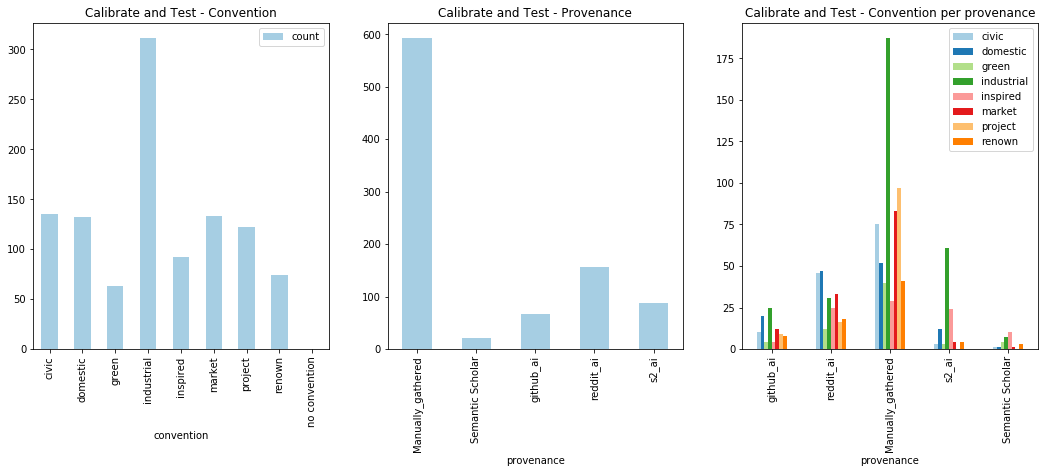

               count
convention          
civic          135.0
domestic       132.0
green          63.0 
industrial     311.0
inspired       92.0 
market         133.0
project        122.0
renown         74.0 
no convention  0.0  
cut size: 0.5
924 Note: this can contain multi-label samples, and samples with no convention

convention civic
Samples needed according to %value: 67
Samples available when some provenances are not used: 135

convention domestic
Samples needed according to %value: 66
Samples available when some provenances are not used: 132

convention green
Samples needed according to %value: 31
Samples available when some provenances are not used: 63

convention industrial
Samples needed according to %value: 155
Samples available when some provenances are not used: 311

convention inspired
Samples needed according to %value: 46
Samples available when some provenances are not used: 92

convention market
Samples needed according to %value: 66
Samples available when some prove

<Figure size 432x288 with 0 Axes>

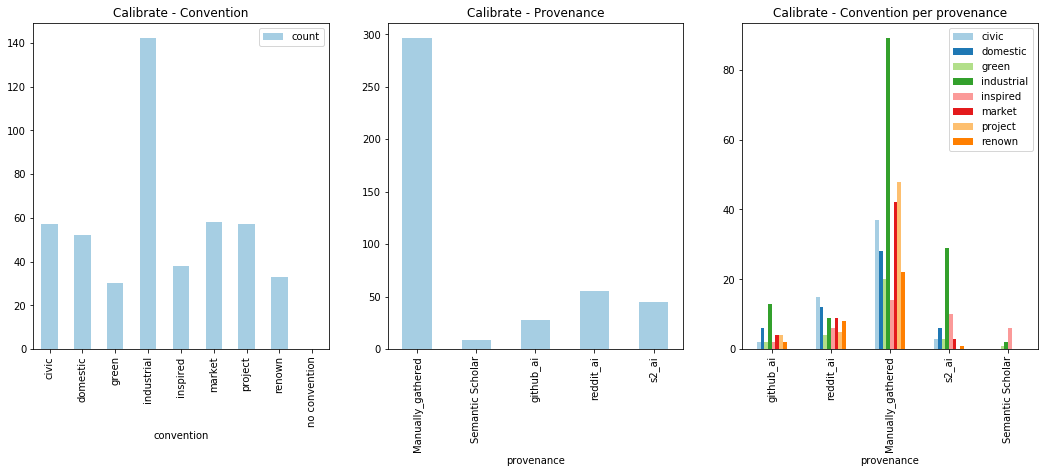

               count
convention          
civic          57.0 
domestic       52.0 
green          30.0 
industrial     142.0
inspired       38.0 
market         58.0 
project        57.0 
renown         33.0 
no convention  0.0  


<Figure size 432x288 with 0 Axes>

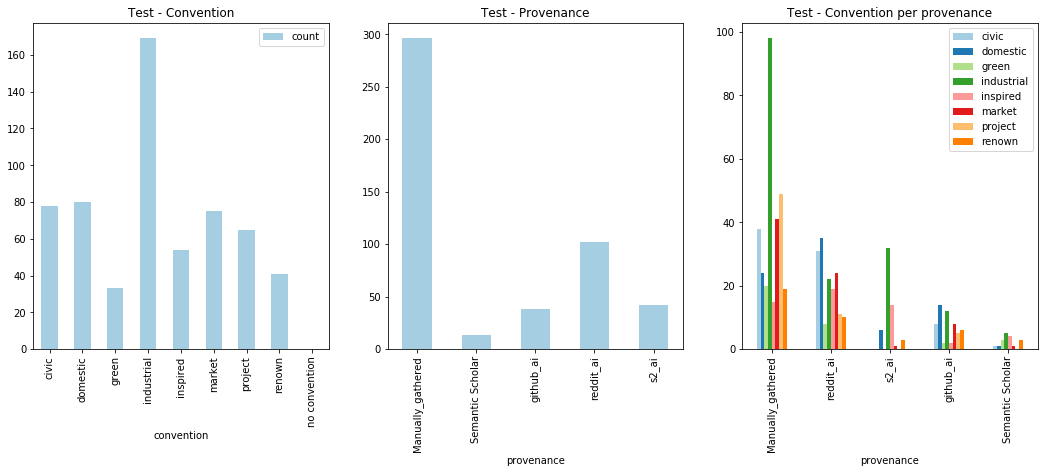

               count
convention          
civic          78.0 
domestic       80.0 
green          33.0 
industrial     169.0
inspired       54.0 
market         75.0 
project        65.0 
renown         41.0 
no convention  0.0  


<Figure size 432x288 with 0 Axes>

In [50]:
display_labelled_data (calibration_test_df, "Calibrate and Test", False)

#keep 50%(per convention) of the calibration_test_df for calibration and 50% for testing.
#the calibration split will be split further later
provenance_b = ['Manually_gathered', 'Semantic Scholar', 's2_ai' ,'github_ai' ,'reddit_ai' ]
calibration_df, test_df = split_data(calibration_test_df, cut_b = .5, provenance_b = provenance_b)
print(calibration_df.shape[0])
print(test_df.shape[0])
display_labelled_data (calibration_df, "Calibrate", False)
display_labelled_data (test_df, "Test", False)

In [51]:
print("quick check for duplicate strings:")
print("Number of unique strings", len(
    calibration_test_df['text'].unique()))
print("Length of data frame", len(calibration_test_df.index))

quick check for duplicate strings:
Number of unique strings 924
Length of data frame 924


# Calibration of individual model confidence (Re-scaling operation) - The probability associated with the predicted class label should reflect its ground truth correctness likelihood. log-loss optimization

<B> The score that each of our 8 convention models gives a sentence is not necessarally the probability that the sentence reflects that convention</B>

Now we have our simple multi-label "Binary Relevance(BR)" classifier i.e  one binary classifier for each of our 8 labels(conventions). BR has two well-known drawbacks. First, BR neglects label dependencies and this often leads to prediction errors: some BR predictions are incomplete, eg. tagging cat but not animal for an image, and some are conflicting, such as predicting both the code "Pain in left knee" and the code "Pain in unspecified knee" for a medical note." In our case there are no label dependencies(no convention dependencies) so this drawback is not an issue.

The second drawback is that the overall set is often not well calibrated. In order for the overall set to be well calibrated the first task will be to ensure that each individula model is well calibrated. A natural requirement in many end-use applications is that the classifier provides a well-calibrated confidence (probability) to indicate the likelihood of the predicted set being correct; for example, an application may automate high-confidence predictions while manually verifying low-confidence predictions. The established procedures are isotonic regression or Platt scaling) "In machine learning, Platt scaling or Platt calibration is a way of transforming the outputs of a classification model into a probability distribution over classes. The method was invented by John Platt in the context of  support vector machines, replacing an earlier method by Vapnik, but can be applied to other classification models. Platt scaling works by fitting a logistic regression model to a classifier's scores." Isotonic regression has been shown to work better than Platt scaling, in particular when enough training data is available. Isotonic Regression is similar to Platt Scaling. It’s a non-parametric regression technique. Non-parametric means that it doesn’t make any assumptions such as of linearity among variables, constant error variance etc. The only difference lies in the function being fit. The function we fit in isotonic regression continuously increases/decreases.  

So at this point the overall system is predicting  the probability that a sentence belonging 
to each of the eight conventions.  In general, the distribution of these probabilities per classifier may 
not match the expected distribution of observed probabilities. The distribution of the probabilities is therefor calibrated(or adjusted) to better match the expected distribution observed in the data. As mentioned this adjustment is a rescaling operation applied after the predictions have been made by the models. This calibration or scaling can be achieved by using for example, Platt Scaling or Isotonic Regression.


A probabilistic model is well calibrated if for example when we 'bin' the test samples based on their predicted probabilities and when we then examine each bin’s true outcomes, the true outcome should have a proportion close to the probabilities in the bin.  If we predict that we are 99% sure, and if we are only right 50% of the time, this is not calibrated because our estimation was too optimistic. Similarly, if we predict that we are only 60% sure, and we are right 80% of the time, this is not calibrated because our estimation was too pessimistic.

If we split our probability 0 to 1 into 10 bins (0-0.1, 0.1-0.2,.... 0.8 to 1) then in the .8 bin 80% of the predictions should in theory be correct(based on true outcomes) as this would basically imply an 80% confidence rating. This information can be reflected in a reliability diagram(or calibration plot). Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

NOTE: For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.

below we plot the reliability diagram for each of our 8 models, against a version calibrated with isotonic regression. 

In [52]:
def predict(thresholds_in, df_in, _tokenizer, _DLModels, _IsotonicRegression):
    thresholds = {'civic': 0.5,
                  'domestic': 0.5,
                  'green': 0.5,
                  'industrial': 0.5,
                  'inspired': 0.5,
                  'market': 0.5,
                  'project': 0.5,
                  'renown': 0.5}
    

    if thresholds_in != None:
        thresholds = thresholds_in
    
    extended_tokenizer = _tokenizer
    df_in = df_in.drop("provenance", axis = 1)
    
    column_list = []
    column_list.append("convention")
    column_list.append("label")
    
    for conv in _DLModels.keys():
        column_list.append(conv)
        column_list.append(conv+"_prob")
        column_list.append(conv+"_y_pred")
        column_list.append(conv+"_prob_1")
        
    all_df = pd.DataFrame(columns=column_list)
    df = pd.DataFrame(columns=column_list)

    #a sub function within the function, just used in this scope 
    def sub_funct_get_prob(prob, y):
        res = []
        for (probability, predicted) in zip(prob, y):
            if predicted == 1:
                res.append(probability)
            if predicted == 0:
                res.append(1 - probability)
        return res
    ####
    
    for conv in _DLModels.keys():
        
        #loop for ever model
        df = pd.DataFrame(columns=column_list)
        #df_in =  text	civic	domestic	green	industrial	inspired	market	project	renown	sequence
        df['text'] = df_in.loc[df_in[conv] == 1, 'text']
        print (conv, "through", conv)
        
        sequences = extended_tokenizer.texts_to_sequences(df['text'])
        data_x = pad_sequences(sequences, maxlen= model_helpers.MAX_SEQUENCE_LENGTH) 
        sequences = 0
        gc.collect()

        y_actual = 1
        df[conv] = y_actual        
        df['label'] = y_actual
        
        #Add a column "convention" so we will always know this is originally labelled for convention x
        #This can then work in conjunction with "label" column, eg green -> 0, or green->1 etc
        df['convention'] = conv
        
        #first get the prediction for this convenion on its own model
        conv_model = _DLModels[conv]   
            
        #First through our model =
        y_predict = conv_model.predict(data_x)
       
            
        #get the score for value = 1 as the response is [x,y] we need only the y values
        y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
          

        #convert the probability to 0 or 1 depending on the threshold.
        y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[conv])
    
   
        #if the call has been made with an isotonic reg calibration model too then call its predict.
        if _IsotonicRegression != None:
            conv_ir = _IsotonicRegression[conv]
            y_pos_predict_isotonic_prob = conv_ir.predict(y_pos_predict_prob)
            #print ("calibrated pos probability", y_pos_predict_isotonic_prob) 
            y_pred = get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[conv])
            #print ("calibrated y predict with thresh", y_pred) 
            y_pos_predict_prob = y_pos_predict_isotonic_prob

        #This is the probability of the y_predict
        df[conv+"_prob"] = sub_funct_get_prob(y_pos_predict_prob , y_pred)
        df[conv+"_y_pred"] = y_pred
        df[conv+"_prob_1"] = y_pos_predict_prob 
    
        #Now put these validation sentences through all the other models.
        #getting a list of all conventions and removing the one we just did
        all_models = list(_DLModels.keys())
        all_other_models = all_models
        all_other_models.remove(conv)
        
            #now for all other models we do the same process       
        for model in all_other_models:
            print (conv, "through", model)
            other_model = _DLModels[model]  
                
            #First through the model
            y_predict = other_model.predict(data_x)
                
            #get the score for value = 1 as the response is [x,y] we need only the y values
            y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
                
            #get the 1 or 0 value depending on the threshold
            y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[model])
              
                
            #print ("y pred", y_pos_predict_prob)  
            #if the call has been made with an isotonic reg calibration model too then call its predict.
            if _DLModelsIsotonicRegression != None:
                other_ir = _DLModelsIsotonicRegression[model]
                y_pos_predict_isotonic_prob = other_ir.predict(y_pos_predict_prob)
                #print ("y pred with calib", y_pos_predict_isotonic_prob) 
                y_pred = get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[model])
                y_pos_predict_prob = y_pos_predict_isotonic_prob
                
            #this is the y_actual value
            df[model] = 0
                
             #leave this alone as it may have been populated before in its own iteration . later any nAn will be converted
             #df['label']  = 0
                
            #The probability of the y_predict, whether it i 1 or 0
            df[model+"_prob"] =  sub_funct_get_prob(y_pos_predict_prob, y_pred)
            df[model+"_y_pred"] = y_pred
            df[model+"_prob_1"] = y_pos_predict_prob         
       
        #up until this point the correct values are in the dataframe in terms of 1's and 0's  
        all_df = pd.concat([all_df, df], sort=False) 

    y_pred_list = []
    for x in all_df.columns.values:
        if x.endswith(('_y_pred')):
            y_pred_list.append(x)
            
    prob_list = []
    conv_list = []
    for x in all_df.columns.values:
        if x.endswith(('_prob')):
            prob_list.append(x)
            conv_list.append(x.replace('_prob', ''))
    
    
    #Check for and remove duplicate rows and duplicate sentences.  
    #Remove any rows where the entire row is a duplicate, keeps first version
#     print ("unique txt", len(all_df.text.unique()))
    all_df = all_df.drop_duplicates(keep = "first")
#     print ("after",all_df.shape[0])
    
    #need to check if it is even necessary to add these.
    #now merge any instances where two conventions had same sample sentence
    all_df = all_df.drop("convention", axis = 1).drop("label", axis = 1)
    agg_funct = {
        'civic':'max', 
        'civic_prob':'first', 
        'civic_y_pred':'first', 
        'civic_prob_1':'first', 
        'domestic':'max',
        'domestic_prob':'first', 
        'domestic_y_pred':'first', 
        'domestic_prob_1':'first',
        'green':'max',
        'green_prob':'first', 
        'green_y_pred':'first', 
        'green_prob_1':'first', 
        'industrial':'max',
        'industrial_prob':'first', 
        'industrial_y_pred':'first', 
        'industrial_prob_1':'first', 
        'inspired':'max',
        'inspired_prob':'first', 
        'inspired_y_pred':'first', 
        'inspired_prob_1':'first', 
        'market':'max',
        'market_prob':'first', 
        'market_y_pred':'first', 
        'market_prob_1':'first', 
        'project':'max',
        'project_prob':'first', 
        'project_y_pred':'first', 
        'project_prob_1':'first', 
        'renown':'max',
        'renown_prob':'first', 
        'renown_y_pred':'first', 
        'renown_prob_1':'first', 
        'text':'first'
        }

    all_df = pd.DataFrame(all_df.groupby(all_df['text']).aggregate(agg_funct))
    all_df  = all_df.drop("text", axis = 1).reset_index()
    
    #End remove dupes
    
    #add the label cardinality as the sum of all the predicted = 1 for sentence for conventions
    pred_sums = all_df[y_pred_list].sum(axis=1)
    all_df['y_lbl_cnt'] = pred_sums
    
    #this will be > 1 if the same sentence was used as True for 2 or more conventions.
    positive_sample = all_df[conv_list].sum(axis=1)
    all_df['actual_lbl_cnt'] = positive_sample
    
    
    #add the overall score as the product of all the individual predicted convention scores
    prob_product= all_df[prob_list].prod(axis=1)
    all_df['set_conf'] = prob_product
    
    all_df = all_df.reset_index(drop=True)
    return all_df.fillna(0), thresholds



def rel_diag(x, y):
    _ = plt.figure(figsize=(12, 6))
    _ = plt.rcParams.update({'font.size': 11})
    _ = plt.rcParams.update({'font.weight': 'normal'})
    _ = plt.plot(x, y, marker='o', linewidth=1,
                     label=convention, color='orange')
    # reference line, legends, and axis labels
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    _ = line.set_transform(transform)
    _ = ax.add_line(line)
    ax.set_title(
            'Calibration plot (reliability diagram) for classifier ' + convention)
    _ = ax.set_xlabel('Predicted probability')
    _ = ax.set_ylabel('True probability in each bin')
    _ = plt.legend()

    plt.show()
    plt.clf()
    gc.collect()


def calibrate_models_view_reliability(df, _DLModels):
    _IsotonicRegression = {}
    display(HTML("<font color = 'green'><h3><left>Calibration plot generated via sklearn.calibration.calibration_curve <br/> Isotonic calibration applied using sklearn.isotonic.IsotonicRegression</left></h3></font>"))
    display(HTML("Isotonic Regression is similar to Platt Scaling. It’s a non-parametric regression technique. Non-parametric means that it doesn’t make any assumptions such as of linearity among variables, constant error variance etc. Note that calibration will not improve accuracy but rather will improve log-loss. The goal of our machine learning models is to minimize this value. A perfect model would have a log loss of 0."))
    print("On real problems where the true conditional probabilities are not known, model calibration can be visualized with reliability diagrams (DeGroot & Fienberg, 1982). First, the prediction space is discretized into ten bins. Cases with predicted value between 0 and 0.1 fall in the first bin, between 0.1 and 0.2 in the second bin, etc. For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.")
    for convention in _DLModels.keys():
        display(HTML("<font color = 'green'><h3><left>" +
                     convention + "</left></h3></font>"))
        
        _IsotonicRegression[convention] = IsotonicRegression(
            out_of_bounds='clip')
        # get the model, the validation data input(data_x) and the predicted label(preds) to compare to the actual label(y_actual).
        model = _DLModels[convention]

     
        data_x, y_actual = get_X_y_from_pd(df, convention)
        

        # data_x and y_actual generated, now both flows are same
        y_predict = model.predict(data_x)
        y_predict = get_positive_preds_probabilities(y_predict)
        
        _IsotonicRegression[convention].fit(y_predict, y_actual)
        y_predict_isotonic = _IsotonicRegression[convention].predict(
            y_predict)

        def kl_norm(x):
            return (2 * (math.exp(x) / (math.exp(x)+1))) - 1

        kullback_leibler_before = kl_norm(stats.entropy(y_actual, y_predict))
        kullback_leibler_after = kl_norm(
            stats.entropy(y_actual, y_predict_isotonic))

        log_loss_before = log_loss(y_actual, y_predict, eps=1e-7)
        log_loss_after = log_loss(y_actual, y_predict_isotonic, eps=1e-7)
        brier_score_before = brier_score_loss(y_actual, y_predict)
        brier_score_after = brier_score_loss(y_actual, y_predict_isotonic)
        roc_auc_score_before = roc_auc_score(y_actual, y_predict)
        roc_auc_score_after = roc_auc_score(y_actual, y_predict_isotonic)
        # Plot the calibration curves for test data which is not callibrated and test data which is callibrated
        y, x = calibration_curve(y_actual, y_predict, n_bins=10)
        y_iso, x_iso = calibration_curve(
            y_actual, y_predict_isotonic, n_bins=10)
        print("Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/")
        print("Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/")

        print("")
        print("* Normalized kullback leibler divergence without calibration: ",
              kullback_leibler_before)
        print("* Normalized kullback leibler divergence with calibration: ",
              kullback_leibler_after)
        print("")
        print("In a way this metric measures the quality of predictions rather than the accuracy. ")
        print("* log loss(cross entropy) without calibration: ", log_loss_before)
        print("* log loss(cross entropy) with calibration: ", log_loss_after)
        print("")
        print("* Brier score(MSE) without calibration: ", brier_score_before)
        print("* Brier score(MSE) with calibration: ", brier_score_after)
        print("")
        print("* ROC AUC score without calibration: ", roc_auc_score_before)
        print("* ROC AUC score with calibration: ", roc_auc_score_after)

        _ = plt.figure(figsize=(12, 6))
        _ = plt.rcParams.update({'font.size': 11})
        _ = plt.rcParams.update({'font.weight': 'normal'})

        ax = plt.subplot(1, 2, 1)
        # only these two lines are calibration curves
        _ = plt.plot(x, y, marker='o', linewidth=1,
                     label=convention, color='green')
        
        _ = plt.plot(x_iso, y_iso, marker='o', linewidth=1,
                     label=convention+'_iso', color='orange')

        # reference line, legends, and axis labels
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax.transAxes
        _ = line.set_transform(transform)
        _ = ax.add_line(line)
        ax.set_title(
            'Calibration plot (reliability diagram) for classifier ' + convention)
        _ = ax.set_xlabel('Predicted probability')
        _ = ax.set_ylabel('True probability in each bin')
        _ = plt.legend()

        ax2 = plt.subplot(1, 2, 2)
        ax2.set_title('y_predict probability distribution ' + convention)
        _ = ax2.hist(y_predict, range=(0, 1), bins=10, label=convention,
                     histtype="step", lw=2, color="green")
        _ = ax2.hist(y_predict_isotonic, range=(0, 1), bins=10, label=convention + '_Iso',
                     histtype="step", lw=2, color="orange")
        _ = ax2.set_xlabel("Mean predicted value")
        _ = ax2.set_ylabel("Count")
        _ = ax2.legend(loc="upper center", ncol=2)

        plt.show()
    plt.clf()
    gc.collect()
    return _IsotonicRegression

In [53]:
print (model_helpers.MAX_SEQUENCE_LENGTH)

32


On real problems where the true conditional probabilities are not known, model calibration can be visualized with reliability diagrams (DeGroot & Fienberg, 1982). First, the prediction space is discretized into ten bins. Cases with predicted value between 0 and 0.1 fall in the first bin, between 0.1 and 0.2 in the second bin, etc. For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.


All sentences 433
civic sentences 57
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7297180232608365
* Normalized kullback leibler divergence with calibration:  0.5887823152036751

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  1.1818915260931526
* log loss(cross entropy) with calibration:  0.27783936325652603

* Brier score(MSE) without calibration:  0.26712682939612314
* Brier score(MSE) with calibration:  0.08339213966503918

* ROC AUC score without calibration:  0.826054497946995
* ROC AUC score with calibration:  0.8474010824934678


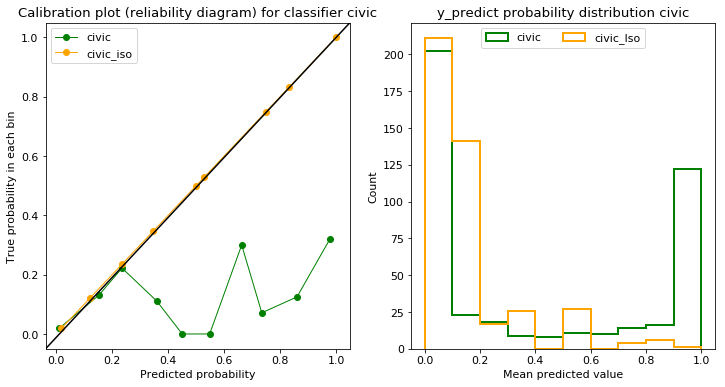

All sentences 433
domestic sentences 52
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7109364717501707
* Normalized kullback leibler divergence with calibration:  0.6532312003685401

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  1.1368535150366277
* log loss(cross entropy) with calibration:  0.2880317779990089

* Brier score(MSE) without calibration:  0.28200145437425805
* Brier score(MSE) with calibration:  0.0875994244436387

* ROC AUC score without calibration:  0.7956289117706441
* ROC AUC score with calibration:  0.8168281849384211


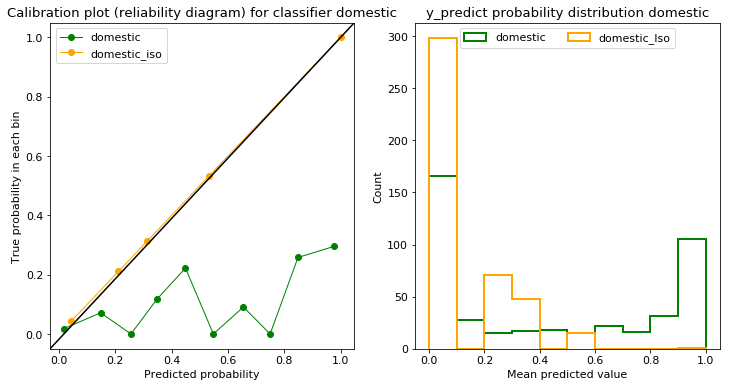

All sentences 433
green sentences 30
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7375586273008488
* Normalized kullback leibler divergence with calibration:  0.645283944874669

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.3442197106625793
* log loss(cross entropy) with calibration:  0.15661353517456816

* Brier score(MSE) without calibration:  0.10469461007167381
* Brier score(MSE) with calibration:  0.04399017144975575

* ROC AUC score without calibration:  0.874110835401158
* ROC AUC score with calibration:  0.8968569065343259


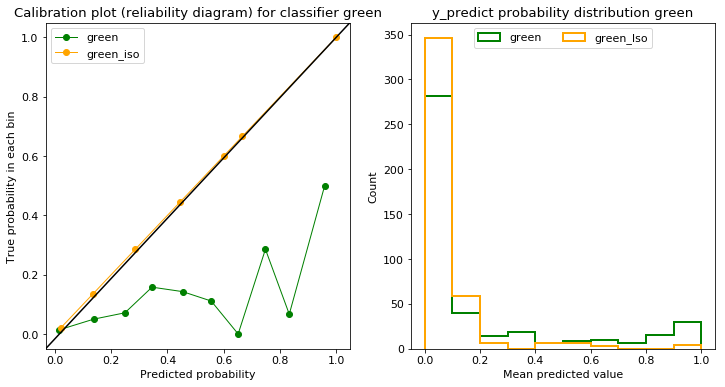

All sentences 433
industrial sentences 142
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.48161847790647405
* Normalized kullback leibler divergence with calibration:  0.3024617136658694

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.6932873385560517
* log loss(cross entropy) with calibration:  0.377583893257707

* Brier score(MSE) without calibration:  0.16770509606958764
* Brier score(MSE) with calibration:  0.12617239029529959

* ROC AUC score without calibration:  0.8738686414016748
* ROC AUC score with calibration:  0.8833551134988626


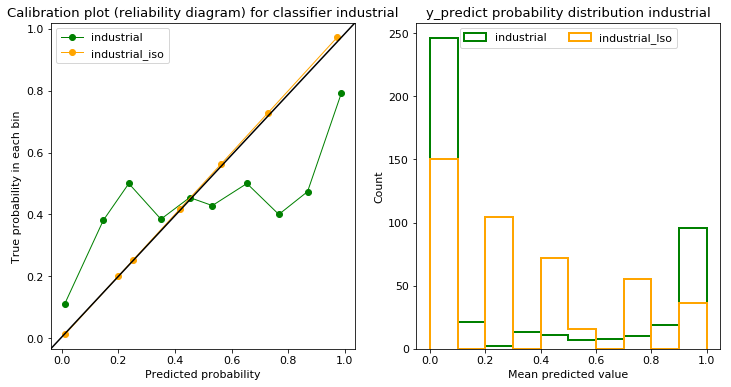

All sentences 433
inspired sentences 38
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.8072512018453082
* Normalized kullback leibler divergence with calibration:  0.7473000013843385

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.5553259812888268
* log loss(cross entropy) with calibration:  0.24488447464671734

* Brier score(MSE) without calibration:  0.18047480321289666
* Brier score(MSE) with calibration:  0.06776469314910943

* ROC AUC score without calibration:  0.7431712191872085
* ROC AUC score with calibration:  0.7692205196535644


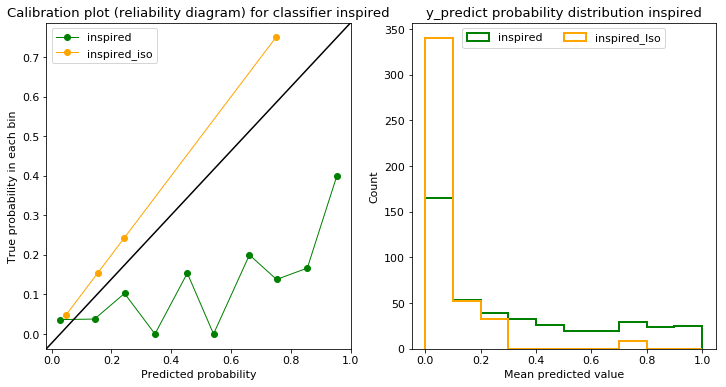

All sentences 433
market sentences 58
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.6583310041784598
* Normalized kullback leibler divergence with calibration:  0.5146876184509126

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.971043964302844
* log loss(cross entropy) with calibration:  0.23158076437433786

* Brier score(MSE) without calibration:  0.2414206350080684
* Brier score(MSE) with calibration:  0.06644309473498947

* ROC AUC score without calibration:  0.8649655172413794
* ROC AUC score with calibration:  0.8819540229885058


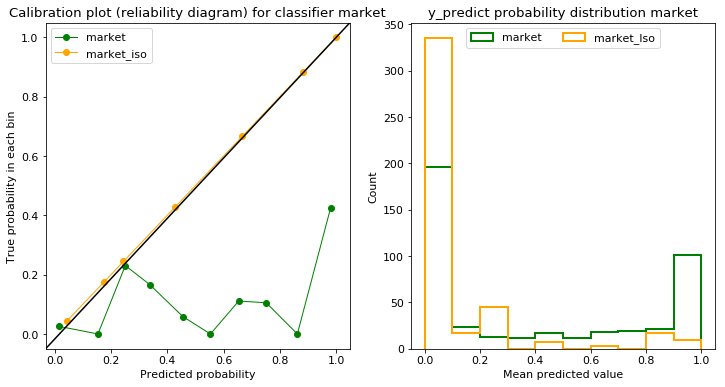

All sentences 433
project sentences 57
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7163838404295444
* Normalized kullback leibler divergence with calibration:  0.6587424863739768

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  0.9312778070665021
* log loss(cross entropy) with calibration:  0.3212595957754683

* Brier score(MSE) without calibration:  0.26708117862146574
* Brier score(MSE) with calibration:  0.09880797573909783

* ROC AUC score without calibration:  0.7608249346771182
* ROC AUC score with calibration:  0.7864408361328853


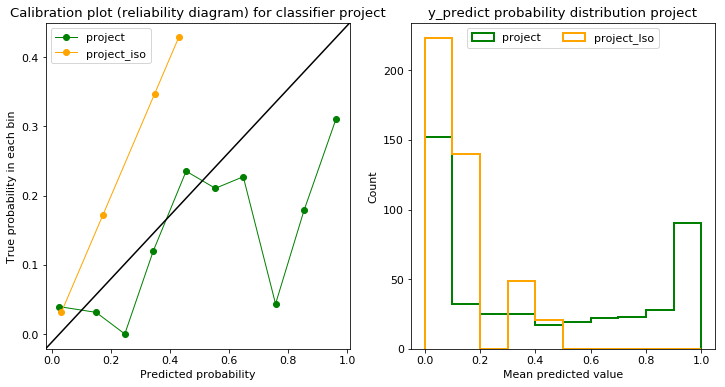

All sentences 433
renown sentences 33
Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
Information on kullback leibler https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

* Normalized kullback leibler divergence without calibration:  0.7771947552350527
* Normalized kullback leibler divergence with calibration:  0.691848913134518

In a way this metric measures the quality of predictions rather than the accuracy. 
* log loss(cross entropy) without calibration:  1.3187907856236336
* log loss(cross entropy) with calibration:  0.1904637966662574

* Brier score(MSE) without calibration:  0.3476926636413233
* Brier score(MSE) with calibration:  0.05431766065973111

* ROC AUC score without calibration:  0.8403030303030303
* ROC AUC score with calibration:  0.8592424242424243


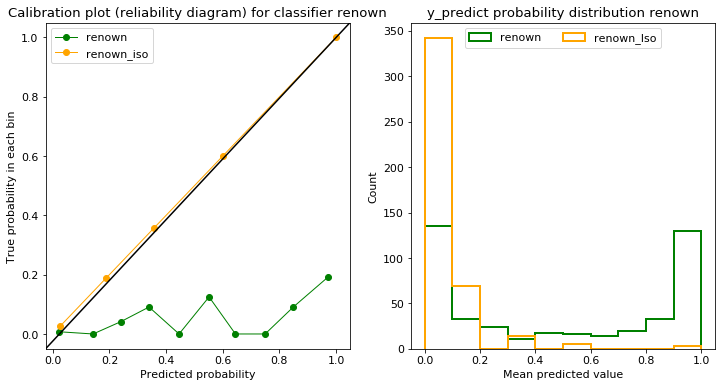

{'civic': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'domestic': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'green': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'industrial': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'inspired': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'market': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'project': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None),
 'renown': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    y_min=None)}

<Figure size 432x288 with 0 Axes>

In [54]:
display(HTML("<font color = 'red'><h3><left>Running Calibration plot and calibration method against calibration/test data</left></h3></font>"))
# Here we are calling the calibration method on the calibration dataset. The method returns the set (one per model)
# of isotonic regression mocels.
calibration_df = get_txt_seq(calibration_df, extended_tokenizer, model_helpers.MAX_SEQUENCE_LENGTH)
_DLModelsIsotonicRegression = {}
_DLModelsIsotonicRegression = calibrate_models_view_reliability(
    calibration_df, _DLModels)
display(_DLModelsIsotonicRegression)

# Now we have a composition of the classifier prediction followed by the isotonic regression model prediction to provide final prediction. 


In [55]:
#Save the calibration models to a pickle file, saving individually so that can store in GIT via api
for conv in _DLModels:
    print (conv, _DLModelsIsotonicRegression[conv])
    model_helpers.store_DL_models_in_picke( conv+"_calibration_model.pickle", 
                                       _DLModelsIsotonicRegression[conv], 
                                       None, 
                                       None, None, None,
                                       paths.RESOURCES_DIR_LOCAL, 
                                       USE_GIT_HUB, 
                                       GIT_USR,
                                       GIT_PSWD)

#Delete the tokenizer for now as it is heavy and we will not use it for a while
#del extended_tokenizer 

civic IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
domestic IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
green IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
industrial IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
inspired IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
market IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
project IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)
renown IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)


# Counting based on calibrated probabilistic output
note that we have two tasks:
    - "Quantification": whereby we need to determine the distribution of conventions amongst the data to be analyze (github and ss)
    - "Multi lable, multi class Classification": In order to facilitate active learning we need to 
    accurately classify the analyzed data for the purpose of auditing random samples and providing additional iterative training data

In [71]:
#move to helper-modules
def get_count_per_model(model, df, num_bins, thresholds):
    #just to remember: we are not using "conf_bin" here it is for the set confidence

    model_count = df[['text', model+'_prob_1',model+'_y_pred', model]].copy()
    model_count['prob_bin'] = pd.qcut(model_count[ model+'_prob_1'], q=num_bins, duplicates='drop')
    model_grouped_count = model_count.groupby('prob_bin')[model+'_prob_1'].count().copy()
    
    mean_prob_per_bucket = []
    occurance_per_bucket = []
    total = 0
    for x in range (len(model_grouped_count)):
        a = model_grouped_count.index.categories[x].left
        b = model_grouped_count.index.categories[x].right
        mean_prob_per_bucket.append (np.mean([a,b]))
        #Crashing for David HERE
        occurance_per_bucket.append (model_grouped_count[x])
#     print (model_grouped_count[x])
    def percentage(percent, whole):
        return (percent * whole) / 100.0
    total = 0
    for prob, occurances in zip(mean_prob_per_bucket,occurance_per_bucket ):
        total = total + percentage(prob*100,occurances)
    
    actual = "not applicable"
    try:
        counts_y_actual = model_count[model]==1
        actual = counts_y_actual.value_counts()[1]
    except:
        actual = "not applicable"
        
    counts_y_predict = model_count[model+'_y_pred']==1
    try:
        predict = counts_y_predict.value_counts()[1]
    except:
        predict = 0
    

    return actual, int(round(total)), predict, thresholds[model]

#move to helper-modules
def get_count(df_in, thresholds, num_prob_buckets = 8, actual=False ):
    plt.clf()
    predicted_prob_count = {}
    predicted_classification_count = {}
    actual_count = {}
    predicted_prob_count_list = []
    predicted_classification_count_list = []
    actual_count_list = []
    model_list = []
    thr_list = []
    thresh = thresholds
    df = pd.DataFrame (columns = ['Convention','Probalistic count','Classifier count','Threshold','True count'])
    for k in thresh: #_DLModels.keys():
        actual_cnt, prob_cnt, classif_cnt, thr = get_count_per_model(k, df_in, num_prob_buckets, thresh)
        predicted_prob_count[k] = prob_cnt
        predicted_classification_count[k] = classif_cnt
        actual_count[k] = actual_cnt
        
        predicted_prob_count_list.append(prob_cnt)
        predicted_classification_count_list.append(classif_cnt)
        actual_count_list.append(actual_cnt)
        model_list.append(k)
        thr_list.append(thr)
    my_colors = ['orange', 'green',  'red', 'pink', 'purple', 'blue', 'brown', 'black']    
    df['Probalistic count'] = predicted_prob_count_list
    df['Classifier count'] = predicted_classification_count_list
    df['True count'] = actual_count_list
    df['Convention'] = model_list
    df['Threshold'] = thr_list
    choose = []
    choose.append(predicted_prob_count [max(predicted_prob_count, key=predicted_prob_count.get)])
    choose.append(predicted_classification_count [max(predicted_classification_count, key=predicted_classification_count.get)])
    choose.append(actual_count [max(actual_count, key=actual_count.get)])
    
    

    fig = go.Figure(data=[
    go.Bar(name='Probabilistic count', x=model_list, y=predicted_prob_count_list, textposition='auto'),
    go.Bar(name='Actual count', x=model_list, y=actual_count_list, textposition='auto'),
    go.Bar(name='Predicted by classifier', x=model_list, y=predicted_classification_count_list, textposition='auto'),
    
    ] )
    # Change the bar mode
    fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text='Probabilistic count vs classifier predicted' )#stack
    fig.show()
    table = ff.create_table(df)
    iplot(table, filename='Count')

    
# # we will use the default thresholds of 0.5
print ("Using calibration")
test_data_with_pred, thresh = predict(None, test_df, extended_tokenizer, _DLModels, _DLModelsIsotonicRegression)
get_count(test_data_with_pred, thresh, num_prob_buckets = 8, actual=True )

#NOTE IF WE ARE NOT USING THE CALIBRATION CAN USE CAL/TEST_DF to TEST
# print ("Not Using calibration")
# test_data_with_pred, thresh = predict(None, calibration_test_df, extended_tokenizer, _DLModels, None)
# get_count(test_data_with_pred, thresh, num_prob_buckets = 8, actual=True )


Using calibration
civic through civic
civic through domestic
civic through green
civic through industrial
civic through inspired
civic through market
civic through project
civic through renown
domestic through domestic
domestic through civic
domestic through green
domestic through industrial
domestic through inspired
domestic through market
domestic through project
domestic through renown
green through green
green through civic
green through domestic
green through industrial
green through inspired
green through market
green through project
green through renown
industrial through industrial
industrial through civic
industrial through domestic
industrial through green
industrial through inspired
industrial through market
industrial through project
industrial through renown
inspired through inspired
inspired through civic
inspired through domestic
inspired through green
inspired through industrial
inspired through market
inspired through project
inspired through renown
market through mark

<Figure size 432x288 with 0 Axes>

In [ ]:
#Free up some meory, just retrieve later if needed!
aivm_helper.save_to_shelf('my_shelf', 'gathered_data_df', gathered_data_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'labelled_data_df', labelled_data_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'training_val_df', training_val_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'calibration_df', calibration_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'test_df', test_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'test_data_with_pred', test_data_with_pred, False, GIT_USR, GIT_PSWD)

#training_df = retrieve_shelved_object('my_shelf', 'training_df')

In [57]:
del gathered_data_df
del labelled_data_df
del training_val_df
# del calibration_df


# Metrics to help select probability threshold for classification
What is the treshold? Each of our models will return the Probability of a sentence belonging to the convention represented by the model. Now this probability needs to be turned into a Classification.
    - Belongs to the convention (Class 1)
    - Does not belong to the convention (Class 0)

we could say that this classification should occur at probability 0.5 however this may not be the best place to put it and for performance of our overall system this "threshold" may vary per model. We will therefor evaluate each individual models performance for a number of performance matrics, for a selection of different classification thresholds, in order to ultimately determine what Threshold  per model to use on unseen data once the model is live.

First we should review metrics for each individual model. In this case our training and evaluation data for each model is very balanced, in that we have an equal amount of Class 1 and Class 0 training sets per model. This balance has been achieved by data resampling either under-sampling the majority of the class, or over-sampling the minority class, or a mix of both(depending on which of the 8 models is in question). This is something to consider when ultimitely deciding the metric to base our threshold decisions on per model (but we should also keep in mind the overall system and the distribution of conventions in unseen(real world) data. 

The Metrics to evaluate:
    * Where Class 1 = Sentence belongs to Convention
    * Where Class 0 = Sentence does not belongs to Convention
 We evaluate against against a gold standard (or the ‘ground truth’ as it is perceived) i.e the true values v's the models predicted valuse in our test/validation data set. 

//////////////////////////////////////////*ACCURACY*/////////////////////////////////////////////////////////////

    - Accuracy = (TP + TN)/(TP + FP + TN + FN)

The probability that the classification result is correct, ie probability of correctly labeling sentences as class 1 or Class 0, given all the sentences!

Accuracy is simply the ratio of the correctly labeled sentences out of all sentences. Accuracy is a good measure  for well balanced datasets and when false negatives & false positive predictions have a similar 'costs'.

With imbalanced data, for example containing a lower amount of Class 1 compared to Class 0,  proclaiming all sentences as class 0 will have quite a high accuracy due to the low overall presence of Class 1, this may not ultimately be a helpful metric though if the cost of a false negative(false class 0) has a high cost. In the case of each of our individual models, our training data is quite balanced and there is a similar cost for FP and FN. however we need to keep in mind that the overall distribution of data in our overall system is not so evenly distributed across the labels that each model represents. 


////////////////////////////*PRECISION/POSITIVE PREDICTION VALUE*//////////////////////////////////////////////

     - Precision or Positive prediction value =  TP / (TP + FP)
     
The probability that a sentences we have labeled as Class 1(belonging to the convention) is actually Class 1. eg in green model, the probability that a sentenced classified as positive(1) for green, is actually green. 

Our focus then in terms of performance might be on identifying the actually positive cases, i.e to maximize the "precision".  Although a model with umbalanced data could also 'cheat' and maximize this by always returning “negative”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is a priority then we should choose a model with higher Recall/Sensitivity. 

   
//////////////////////////////*RECALL/SENSITIVITY/TRUE POSITIVE RATE*/////////////////////////////////////////
 
     - Recall or Sensitivity or TPR =  TP / (TP + FN)
     
Given the sentence is part of the convention, how likely is it that the classification will be positive?

Our focus then in terms of performance could maybe be in terms of higher importance on identifying the positive cases, i.e to maximize the "recall" or "sensitivity". Although a model could also 'cheat' and maximize this by always returning “positive”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is most important to us then we should choose a model with higher Recall/Sensitivity. 

//////////////////////////////*SPECIFITY/TRUE NEGATIVE RATE*//////////////////////////////////////////////////   

    - Specifity or TNR = TN / (TN + FP)

How good a classifier is at avoiding false alarms. Given the sentence does not belong to the convention, how likely is it that the classification will be negative(class 0). If correctly identifying negatives is most important, then we should choose specificity as the measurement metric. A classifier can 'cheat' and maximize this by always returning “negative”/Class 0.


///////////////////////////////////*F1, F2 and F0.5 SCORE*////////////////////////////////////////////////

    - F1 =  2 * ( (Precision * Recall) / (Precision + Recall) )
If we want to find an optimal blend of precision and recall we can combine the two metrics using what is called the F1 score, this is the 'harmonic mean' of precision and recall (harmonic mean is used as it punishes extreme values)

Note: there are other F measures:
F2 which weights recall higher than precision
F0.5 which puts more emphasis on precision than recall.

Fx = (1 + x^2) * ( (precision * recall) / (x^2 *(Precision + Recall)) 


///////////////////////////////////////////////////////////////////////////////////////////////////////////   

It is importalt to look at all relevant metrics instead of just one and to make a decision based on the problem to be resolved (the purpose of the classifier and the importance/impact of incorrectly classifying as positive vs' incorrectly classifying as negative for example it is worse to falsely imprison an innocent person than to let a guilty criminal get away, however the cost attached to FP's and FN'S in our sentence classification is of a different nature. 

    -ROC Curves summarize the trade-off between the true positive rate(recall) and false positive rate for a predictive model. AUC exists independently of a threshold, whereas accuracy / precision / recall / F1-score DO require the picking of a threshold, so we are measuring two different things.

    -Precision-Recall curves summarize the trade-off between the recall(true positive rate) and the Precision(positive predictive value) for a predictive model using different probability thresholds.

Note: ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.


     -Log Loss: This Evaluation Metric is employed in the classification tasks where rather than predicting the actual classes, one needs to predict the probabilities corresponding to that classes. So, in a way this metric measures the quality of predictions rather than the accuracy.

Metrics for civic per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,civic,0.0,78,78,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,civic,0.1,66,42,36,12,0.653846,0.611111,0.846154,0.709677,0.785714,0.647059,0.461538,0.846154,0.538462
2,civic,0.2,49,13,65,29,0.730769,0.790323,0.628205,0.7,0.65508,0.751534,0.833333,0.628205,0.166667
3,civic,0.3,40,11,67,38,0.685897,0.784314,0.512821,0.620155,0.550964,0.70922,0.858974,0.512821,0.141026
4,civic,0.4,30,5,73,48,0.660256,0.857143,0.384615,0.530973,0.432277,0.688073,0.935897,0.384615,0.0641026
5,civic,0.5,30,5,73,48,0.660256,0.857143,0.384615,0.530973,0.432277,0.688073,0.935897,0.384615,0.0641026
6,civic,0.6,16,2,76,62,0.589744,0.888889,0.205128,0.333333,0.242424,0.533333,0.974359,0.205128,0.025641
7,civic,0.7,16,1,77,62,0.596154,0.941176,0.205128,0.336842,0.243161,0.547945,0.987179,0.205128,0.0128205
8,civic,0.8,10,0,78,68,0.564103,1,0.128205,0.227273,0.15528,0.423729,1,0.128205,0
9,civic,0.9,5,0,78,73,0.532051,1,0.0641026,0.120482,0.0788644,0.255102,1,0.0641026,0


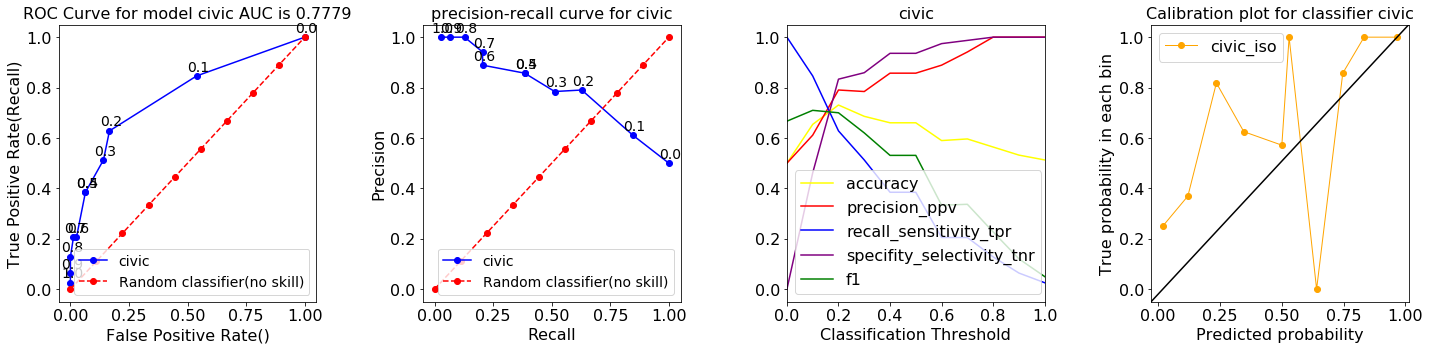

Max evaluation metric for model civic
Threshold dependant metrics:
* Accuracy:  0.7307692307692307 at threshold  0.2
* Precision:  1.0 at threshold  0.8
* Recall:  1.0 at threshold  0.0
* F1:  0.7096774193548387 at threshold  0.1

General Model metrics:
* ROC-AUC 0.7779
* Log Loss 0.9796737232142891
* Brier score 0.2623555813901154
* KL Divergence nan



Metrics for domestic per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,domestic,0.0,80,80,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,domestic,0.1,61,25,55,19,0.725,0.709302,0.7625,0.73494,0.751232,0.71934,0.6875,0.7625,0.3125
2,domestic,0.2,61,24,56,19,0.73125,0.717647,0.7625,0.739394,0.753086,0.72619,0.7,0.7625,0.3
3,domestic,0.3,40,10,70,40,0.6875,0.8,0.5,0.615385,0.540541,0.714286,0.875,0.5,0.125
4,domestic,0.4,13,2,78,67,0.56875,0.866667,0.1625,0.273684,0.19403,0.464286,0.975,0.1625,0.025
5,domestic,0.5,12,1,79,68,0.56875,0.923077,0.15,0.258065,0.18018,0.454545,0.9875,0.15,0.0125
6,domestic,0.6,1,0,80,79,0.50625,1,0.0125,0.0246914,0.0155763,0.0595238,1,0.0125,0
7,domestic,0.7,1,0,80,79,0.50625,1,0.0125,0.0246914,0.0155763,0.0595238,1,0.0125,0
8,domestic,0.8,1,0,80,79,0.50625,1,0.0125,0.0246914,0.0155763,0.0595238,1,0.0125,0
9,domestic,0.9,0,0,80,80,0.5,0,0,0,0,0,1,0,0


<Figure size 432x288 with 0 Axes>

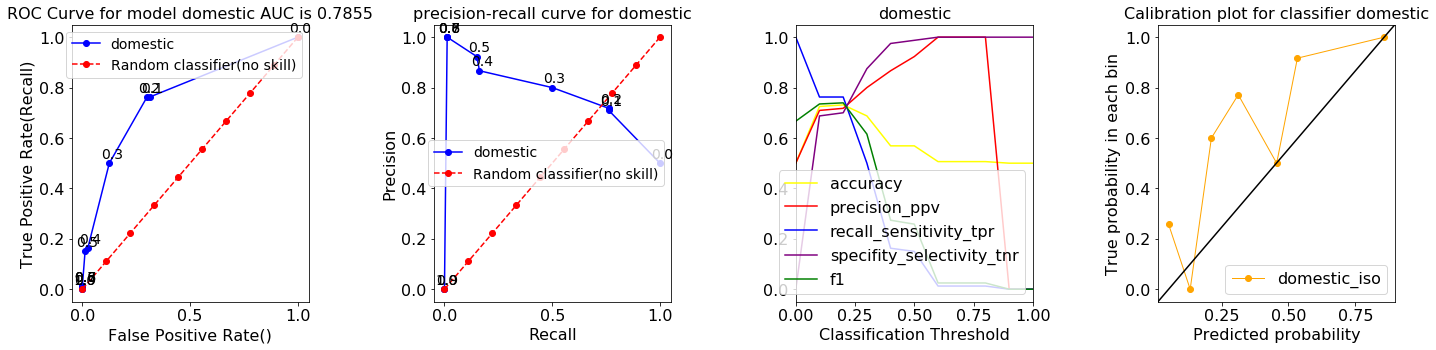

Max evaluation metric for model domestic
Threshold dependant metrics:
* Accuracy:  0.73125 at threshold  0.2
* Precision:  1.0 at threshold  0.6
* Recall:  1.0 at threshold  0.0
* F1:  0.7393939393939394 at threshold  0.2

General Model metrics:
* ROC-AUC 0.7855
* Log Loss 0.8467079572934448
* Brier score 0.295096227042882
* KL Divergence 0.2906398474346885



Metrics for green per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,green,0.0,33,33,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,green,0.1,22,6,27,11,0.742424,0.785714,0.666667,0.721311,0.6875,0.758621,0.818182,0.666667,0.181818
2,green,0.2,11,1,32,22,0.651515,0.916667,0.333333,0.488889,0.381944,0.679012,0.969697,0.333333,0.030303
3,green,0.3,10,1,32,23,0.636364,0.909091,0.30303,0.454545,0.34965,0.649351,0.969697,0.30303,0.030303
4,green,0.4,10,1,32,23,0.636364,0.909091,0.30303,0.454545,0.34965,0.649351,0.969697,0.30303,0.030303
5,green,0.5,9,1,32,24,0.621212,0.9,0.272727,0.418605,0.316901,0.616438,0.969697,0.272727,0.030303
6,green,0.6,7,1,32,26,0.590909,0.875,0.212121,0.341463,0.25,0.538462,0.969697,0.212121,0.030303
7,green,0.7,2,0,33,31,0.530303,1,0.0606061,0.114286,0.0746269,0.243902,1,0.0606061,0
8,green,0.8,2,0,33,31,0.530303,1,0.0606061,0.114286,0.0746269,0.243902,1,0.0606061,0
9,green,0.9,2,0,33,31,0.530303,1,0.0606061,0.114286,0.0746269,0.243902,1,0.0606061,0


<Figure size 432x288 with 0 Axes>

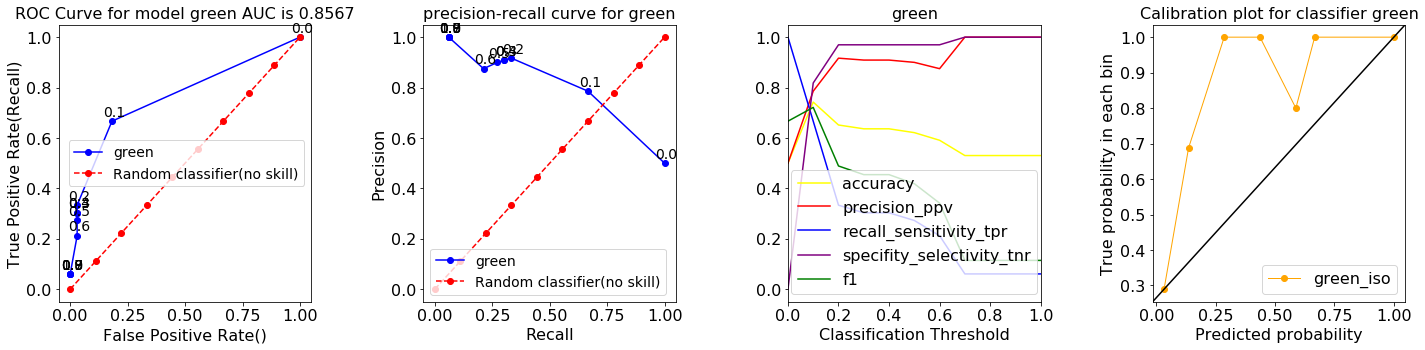

Max evaluation metric for model green
Threshold dependant metrics:
* Accuracy:  0.7424242424242424 at threshold  0.1
* Precision:  1.0 at threshold  0.7
* Recall:  1.0 at threshold  0.0
* F1:  0.721311475409836 at threshold  0.1

General Model metrics:
* ROC-AUC 0.8567
* Log Loss 1.12901587754676
* Brier score 0.30637399564901596
* KL Divergence nan



Metrics for industrial per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,industrial,0.0,169,169,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,industrial,0.1,160,92,77,9,0.701183,0.634921,0.946746,0.760095,0.862069,0.679694,0.455621,0.946746,0.544379
2,industrial,0.2,160,92,77,9,0.701183,0.634921,0.946746,0.760095,0.862069,0.679694,0.455621,0.946746,0.544379
3,industrial,0.3,126,35,134,43,0.769231,0.782609,0.745562,0.763636,0.752688,0.774908,0.792899,0.745562,0.207101
4,industrial,0.4,126,33,136,43,0.775148,0.792453,0.745562,0.768293,0.754491,0.782609,0.804734,0.745562,0.195266
5,industrial,0.5,93,8,161,76,0.751479,0.920792,0.550296,0.688889,0.598456,0.811518,0.952663,0.550296,0.0473373
6,industrial,0.6,90,7,162,79,0.745562,0.927835,0.532544,0.676692,0.582147,0.807899,0.95858,0.532544,0.0414201
7,industrial,0.7,90,7,162,79,0.745562,0.927835,0.532544,0.676692,0.582147,0.807899,0.95858,0.532544,0.0414201
8,industrial,0.8,42,1,168,127,0.621302,0.976744,0.248521,0.396226,0.292072,0.615836,0.994083,0.248521,0.00591716
9,industrial,0.9,42,1,168,127,0.621302,0.976744,0.248521,0.396226,0.292072,0.615836,0.994083,0.248521,0.00591716


<Figure size 432x288 with 0 Axes>

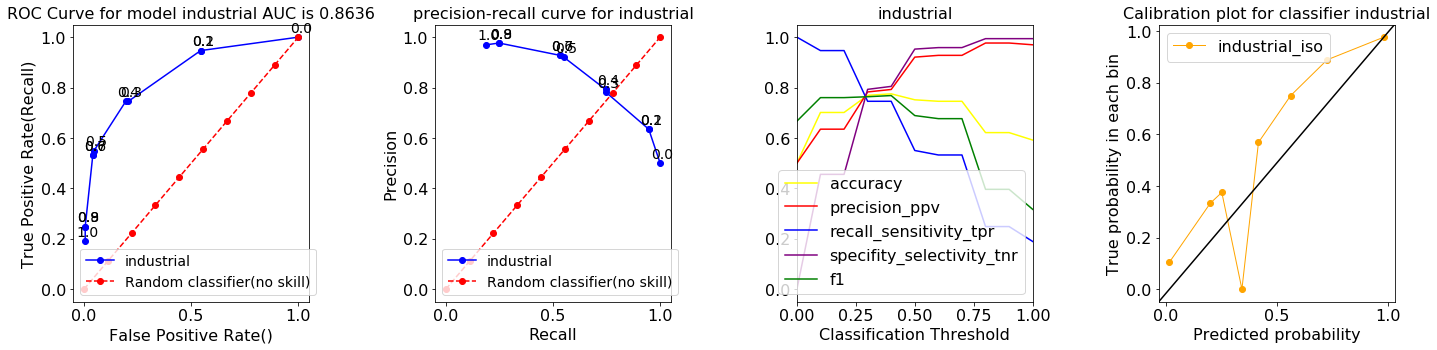

Max evaluation metric for model industrial
Threshold dependant metrics:
* Accuracy:  0.7751479289940828 at threshold  0.4
* Precision:  0.9767441860465116 at threshold  0.8
* Recall:  1.0 at threshold  0.0
* F1:  0.7682926829268293 at threshold  0.4

General Model metrics:
* ROC-AUC 0.8636
* Log Loss 0.544655004014555
* Brier score 0.16379997157337106
* KL Divergence 0.25170335086597206



Metrics for inspired per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,inspired,0.0,54,54,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,inspired,0.1,33,10,44,21,0.712963,0.767442,0.611111,0.680412,0.637066,0.730088,0.814815,0.611111,0.185185
2,inspired,0.2,22,6,48,32,0.648148,0.785714,0.407407,0.536585,0.45082,0.662651,0.888889,0.407407,0.111111
3,inspired,0.3,6,1,53,48,0.546296,0.857143,0.111111,0.196721,0.134529,0.365854,0.981481,0.111111,0.0185185
4,inspired,0.4,6,1,53,48,0.546296,0.857143,0.111111,0.196721,0.134529,0.365854,0.981481,0.111111,0.0185185
5,inspired,0.5,6,1,53,48,0.546296,0.857143,0.111111,0.196721,0.134529,0.365854,0.981481,0.111111,0.0185185
6,inspired,0.6,6,1,53,48,0.546296,0.857143,0.111111,0.196721,0.134529,0.365854,0.981481,0.111111,0.0185185
7,inspired,0.7,6,1,53,48,0.546296,0.857143,0.111111,0.196721,0.134529,0.365854,0.981481,0.111111,0.0185185
8,inspired,0.8,0,0,54,54,0.5,0,0,0,0,0,1,0,0
9,inspired,0.9,0,0,54,54,0.5,0,0,0,0,0,1,0,0


<Figure size 432x288 with 0 Axes>

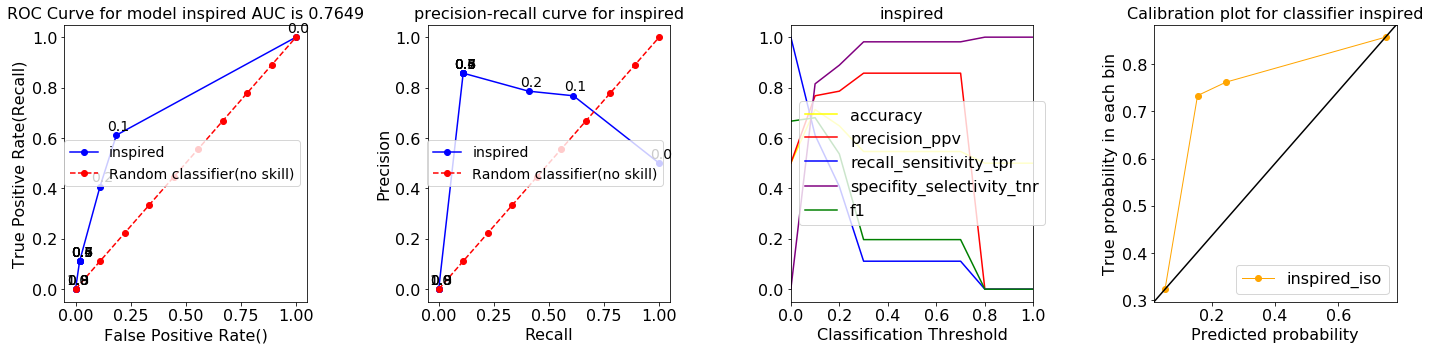

Max evaluation metric for model inspired
Threshold dependant metrics:
* Accuracy:  0.7129629629629629 at threshold  0.1
* Precision:  0.8571428571428571 at threshold  0.3
* Recall:  1.0 at threshold  0.0
* F1:  0.6804123711340206 at threshold  0.1

General Model metrics:
* ROC-AUC 0.7649
* Log Loss 1.3728493830991624
* Brier score 0.3441887171432444
* KL Divergence nan



Metrics for market per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,market,0.0,75,75,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,market,0.1,48,10,65,27,0.753333,0.827586,0.64,0.721805,0.670391,0.781759,0.866667,0.64,0.133333
2,market,0.2,43,6,69,32,0.746667,0.877551,0.573333,0.693548,0.616046,0.793358,0.92,0.573333,0.08
3,market,0.3,27,0,75,48,0.68,1,0.36,0.529412,0.412844,0.737705,1,0.36,0
4,market,0.4,27,0,75,48,0.68,1,0.36,0.529412,0.412844,0.737705,1,0.36,0
5,market,0.5,20,0,75,55,0.633333,1,0.266667,0.421053,0.3125,0.645161,1,0.266667,0
6,market,0.6,20,0,75,55,0.633333,1,0.266667,0.421053,0.3125,0.645161,1,0.266667,0
7,market,0.7,16,0,75,59,0.606667,1,0.213333,0.351648,0.253165,0.57554,1,0.213333,0
8,market,0.8,16,0,75,59,0.606667,1,0.213333,0.351648,0.253165,0.57554,1,0.213333,0
9,market,0.9,10,0,75,65,0.566667,1,0.133333,0.235294,0.16129,0.434783,1,0.133333,0


<Figure size 432x288 with 0 Axes>

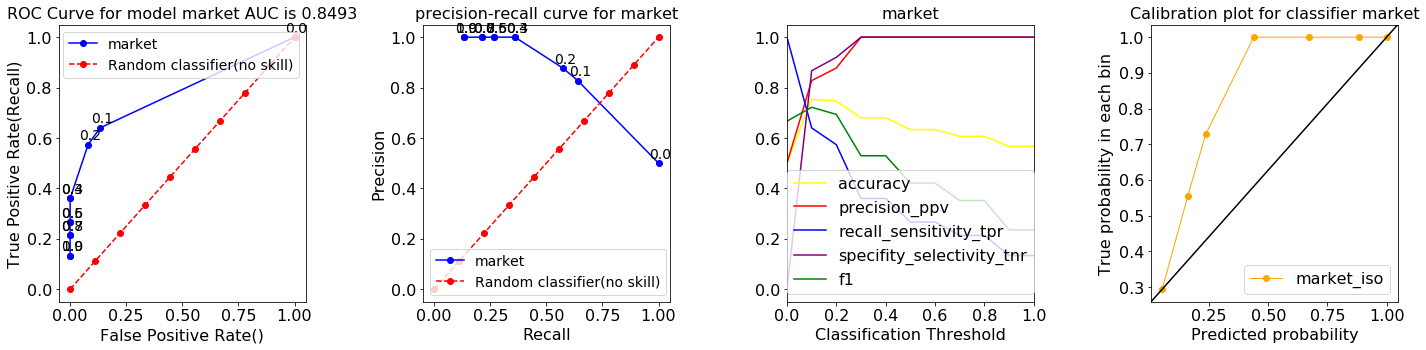

Max evaluation metric for model market
Threshold dependant metrics:
* Accuracy:  0.7533333333333333 at threshold  0.1
* Precision:  1.0 at threshold  0.3
* Recall:  1.0 at threshold  0.0
* F1:  0.7218045112781956 at threshold  0.1

General Model metrics:
* ROC-AUC 0.8493
* Log Loss 0.7859159070027882
* Brier score 0.2624384134457408
* KL Divergence 0.320733248719699



Metrics for project per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,project,0.0,65,65,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,project,0.1,55,40,25,10,0.615385,0.578947,0.846154,0.6875,0.774648,0.617978,0.384615,0.846154,0.615385
2,project,0.2,31,17,48,34,0.607692,0.645833,0.476923,0.548673,0.503247,0.603113,0.738462,0.476923,0.261538
3,project,0.3,31,17,48,34,0.607692,0.645833,0.476923,0.548673,0.503247,0.603113,0.738462,0.476923,0.261538
4,project,0.4,14,5,60,51,0.569231,0.736842,0.215385,0.333333,0.250896,0.496454,0.923077,0.215385,0.0769231
5,project,0.5,0,0,65,65,0.5,0,0,0,0,0,1,0,0
6,project,0.6,0,0,65,65,0.5,0,0,0,0,0,1,0,0
7,project,0.7,0,0,65,65,0.5,0,0,0,0,0,1,0,0
8,project,0.8,0,0,65,65,0.5,0,0,0,0,0,1,0,0
9,project,0.9,0,0,65,65,0.5,0,0,0,0,0,1,0,0


<Figure size 432x288 with 0 Axes>

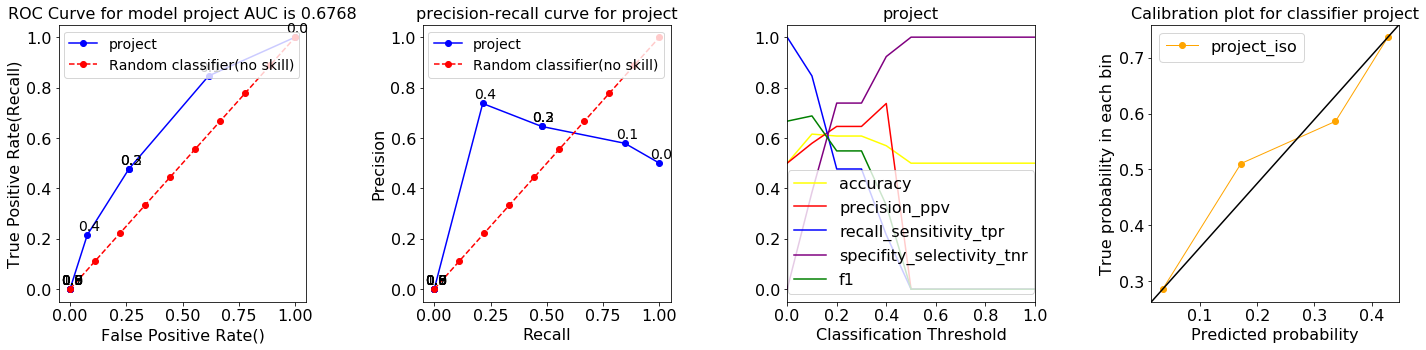

Max evaluation metric for model project
Threshold dependant metrics:
* Accuracy:  0.6153846153846154 at threshold  0.1
* Precision:  0.7368421052631579 at threshold  0.4
* Recall:  1.0 at threshold  0.0
* F1:  0.6875 at threshold  0.1

General Model metrics:
* ROC-AUC 0.6768
* Log Loss 0.9096894815691918
* Brier score 0.314124181186838
* KL Divergence 0.35739268546799896



Metrics for renown per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,renown,0.0,41,41,0,0,0.5,0.5,1,0.666667,0.833333,0.555556,0,1,1
1,renown,0.1,23,7,34,18,0.695122,0.766667,0.560976,0.647887,0.592784,0.714286,0.829268,0.560976,0.170732
2,renown,0.2,12,1,40,29,0.634146,0.923077,0.292683,0.444444,0.338983,0.645161,0.97561,0.292683,0.0243902
3,renown,0.3,12,1,40,29,0.634146,0.923077,0.292683,0.444444,0.338983,0.645161,0.97561,0.292683,0.0243902
4,renown,0.4,7,0,41,34,0.585366,1,0.170732,0.291667,0.204678,0.507246,1,0.170732,0
5,renown,0.5,7,0,41,34,0.585366,1,0.170732,0.291667,0.204678,0.507246,1,0.170732,0
6,renown,0.6,7,0,41,34,0.585366,1,0.170732,0.291667,0.204678,0.507246,1,0.170732,0
7,renown,0.7,2,0,41,39,0.52439,1,0.0487805,0.0930233,0.060241,0.204082,1,0.0487805,0
8,renown,0.8,2,0,41,39,0.52439,1,0.0487805,0.0930233,0.060241,0.204082,1,0.0487805,0
9,renown,0.9,2,0,41,39,0.52439,1,0.0487805,0.0930233,0.060241,0.204082,1,0.0487805,0


<Figure size 432x288 with 0 Axes>

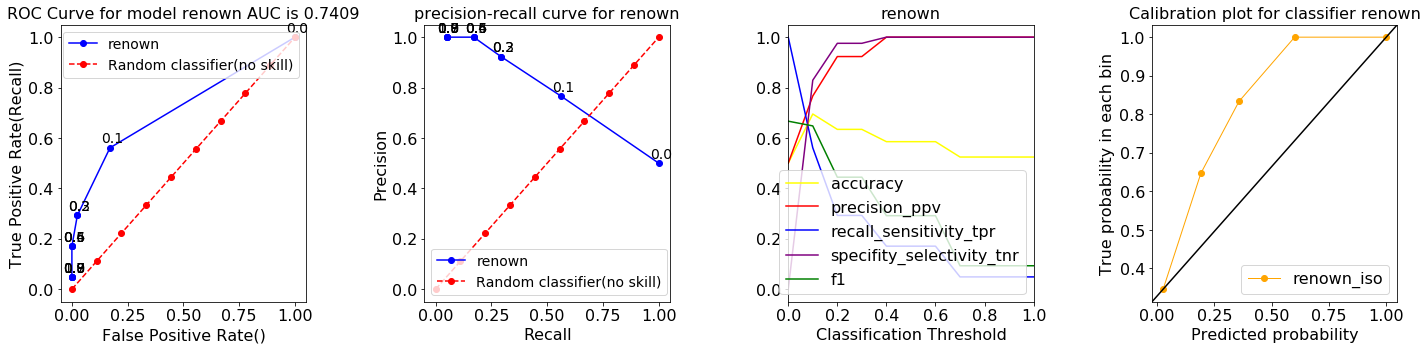

Max evaluation metric for model renown
Threshold dependant metrics:
* Accuracy:  0.6951219512195121 at threshold  0.1
* Precision:  1.0 at threshold  0.4
* Recall:  1.0 at threshold  0.0
* F1:  0.6666666666666666 at threshold  0.0

General Model metrics:
* ROC-AUC 0.7409
* Log Loss 1.8482156465907098
* Brier score 0.3337987403001157
* KL Divergence nan


<Figure size 432x288 with 0 Axes>

In [72]:
def review_model_metrics(df_in, _DLModels, balance_data ):
    #Generate a list of 100 possible tresholds between 0 and .96, 
    # AF why .96?
    #thresholds = np.linspace(0,0.96,100)
    #thresholds = np.linspace(0,1,10)
    #AF: We could evaluate thresholds from 0.0 to 1.0 in increments of 0.1?
    thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    tn_list = []
    fp_list = [] 
    fn_list = []
    tp_list = []

    dict_opt_f1_threshold = {}
    dict_opt_precision_threshold = {}
    dict_opt_recall_threshold = {}
    dict_opt_accuracy_threshold = {}
    dict_roc_auc = {}
    dict_log_loss = {}
    dict_kl = {}
    dict_brier = {}

    SMALL_SIZE = 8
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    def kl_norm(x):
        return  (2 * (  math.exp(x)/ ( math.exp(x)+1 ) ) ) - 1
       

    metrics_for_all = pd.DataFrame()

    #at each step calculating the precision, recall, F1, and location on the ROC curve. 
    
    for k in _DLModels.keys(): #i.e for each convention
        tn_list = []
        fp_list = [] 
        fn_list = []
        tp_list = []
        
        #print ("Num positive samples:", len(df_in[df_in[k] == 1]))
        #show the reliability and calibrate
        #df_in will contain the values for convention k label = 1 and 0 and is unbalanced at this point
        if balance_data == False: #don't artifically balance the data
            df = df_in
            
        else: #if balance_data == False: #artifically balance the data
            temp1 = df_in[df_in[k] == 1]
            temp2 = df_in[df_in[k] == 0].sample(n = temp1.shape[0])
            df = pd.concat([temp1, temp2])
            
            
        y_actual = df[k].values
    
        pos_predict_prob = df[k+'_prob_1'].values
    
        dict_kl[k] = kl_norm(stats.entropy(y_actual, pos_predict_prob))
        dict_roc_auc[k] = roc_auc_score(y_actual ,pos_predict_prob).round(4)
        dict_log_loss[k] = log_loss(y_actual , pos_predict_prob, eps = 1e-7 )
        dict_brier[k] = brier_score_loss(y_actual, pos_predict_prob)

    
    
        for t in thresholds:
            y_pred = get_positive_preds_with_threshold(pos_predict_prob, t)
            confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)
            tn, fp, fn, tp = confusion_matrix.ravel()
            tn_list.append(tn)
            fp_list.append(fp)
            fn_list.append(fn)
            tp_list.append(tp)
        print ("")
        display (HTML("<font color = green><h3><left>*** " + k + "***</left></h3></font>"))
        results_for_current_convention = pd.DataFrame({'threshold': thresholds,
                            'tp': tp_list,
                            'fp': fp_list,
                            'tn': tn_list,
                            'fn': fn_list
                           })
   
        metrics_df =  calculate_metrics(results_for_current_convention, len(y_actual), k);
        print("Metrics for " +k + " per Classification Threshold")
        display(metrics_df)
        metrics_for_all = pd.concat([metrics_for_all,metrics_df], sort = False)
    
        plt.figure(figsize=(20,5))
        plt.style.use('seaborn-dark-palette')
        plt.rc('font', size =MEDIUM_SIZE )                  # controls default text sizes
        plt.rc('axes', titlesize=BIGGER_SIZE)   # fontsize of the axes title
        plt.rc('axes', labelsize=BIGGER_SIZE)   # fontsize of the x and y labels
        plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
        ax1 = plt.subplot(1, 4, 1)
        my_thresholds = [str(t) for t in metrics_df['threshold']]
        ax1.plot(metrics_df['fpr'], metrics_df['tpr'], 'bo-', label = k);
        ax1.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'Random classifier(no skill)');
        for x, y, s in zip(metrics_df['fpr'], metrics_df['tpr'], my_thresholds):
            ax1.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});
        ax1.legend(prop={'size':14})
        ax1.set_ylabel('True Positive Rate(Recall)'); 
        ax1.set_xlabel('False Positive Rate()');
        ax1.set_title('ROC Curve for model '+k + " AUC is " + str(dict_roc_auc[k]))
        #plt.show()
        #plt.clf()
    

        ax2 = plt.subplot(1, 4, 2)
        ax2.plot(metrics_df['recall_sensitivity_tpr'], metrics_df['precision_ppv'], 'bo-', label = k);
        ax2.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'Random classifier(no skill)');
        for x, y, s in zip(metrics_df['recall_sensitivity_tpr'], metrics_df['precision_ppv'], my_thresholds):
            ax2.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});
        ax2.legend(prop={'size':14})
        ax2.set_ylabel('Precision'); plt.xlabel('Recall');
        ax2.set_title('precision-recall curve for '+k )
        #plt.show()
        #plt.clf()
    
        ax3 = plt.subplot(1, 4, 3)
        ax3 = plt.gca()
        ax3.set_title(k)
        metrics_df.plot(kind='line',x='threshold',y='accuracy', color='yellow',ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='precision_ppv', color='red', ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='recall_sensitivity_tpr', color='blue',ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='specifity_selectivity_tnr', color='purple',ax=ax3)
        metrics_df.plot(kind='line',x='threshold',y='f1', color='green', ax=ax3)
        ax3.set_xlabel('Classification Threshold')
        
        
        ax4 = plt.subplot(1, 4, 4)
        #plot the calibration curve just to confirm the calibration
        y_iso, x_iso = calibration_curve(y_actual, pos_predict_prob, n_bins=10);
        _ = plt.rcParams.update({'font.size': 11})
        _ = plt.rcParams.update({'font.weight': 'normal'})
        _ = plt.plot(x_iso, y_iso, marker='o', linewidth=1, label=k+'_iso', color='orange');
        # reference line, legends, and axis labels
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax4.transAxes
        _ = line.set_transform(transform)
        _ = ax4.add_line(line)
        ax4.set_title ('Calibration plot for classifier ' + k) 
        _ = ax4.set_xlabel('Predicted probability')
        _ = ax4.set_ylabel('True probability in each bin')
        _ = plt.legend()
    ####################################################################
        plt.tight_layout()
        plt.show()
        plt.clf()
        print ("Max evaluation metric for model", k)

        best = metrics_df[['recall_sensitivity_tpr','precision_ppv', 'f1', 'accuracy']].max()
        try:
            best_precision_threshold = metrics_df[['threshold']][metrics_df.precision_ppv == best[1]]['threshold'].iloc[0]
        except:
            best_precision_threshold = metrics_df[['threshold']][metrics_df.precision_ppv == best[1]]['threshold'] 
    
        try:
            best_recall_threshold = metrics_df[['threshold']][metrics_df.recall_sensitivity_tpr == best[0]]['threshold'].iloc[0]     
        except:
            best_recall_threshold = metrics_df[['threshold']][metrics_df.recall_sensitivity_tpr == best[0]]['threshold']
    
        try:
            best_F1_threshold = metrics_df[['threshold']][metrics_df.f1 == best[2]]['threshold'].iloc[0] 
        except:
            best_F1_threshold = metrics_df[['threshold']][metrics_df.f1 == best[2]]['threshold']
        
        try:
            best_accuracy_threshold = metrics_df[['threshold']][metrics_df.accuracy == best[3]]['threshold'].iloc[0] 
        except:
            best_accuracy_threshold = metrics_df[['threshold']][metrics_df.accuracy == best[3]]['threshold']
   
        dict_opt_f1_threshold[k] = best_F1_threshold
        dict_opt_precision_threshold[k] = best_precision_threshold
        dict_opt_recall_threshold[k]  =  best_recall_threshold
        dict_opt_accuracy_threshold[k]  =  best_accuracy_threshold
        print ("Threshold dependant metrics:")
        print ("* Accuracy: ", best [3], "at threshold ", best_accuracy_threshold)
        print ("* Precision: ", best [1], "at threshold ", best_precision_threshold)
        print ("* Recall: ", best [0], "at threshold ", best_recall_threshold)
        print ("* F1: ", best [2], "at threshold ", best_F1_threshold)
        print("")
        print ("General Model metrics:")
        print ("* ROC-AUC", dict_roc_auc[k])
        print ("* Log Loss",dict_log_loss[k])                
        print ("* Brier score", dict_brier[k])
        print ("* KL Divergence", dict_kl[k])
    gc.collect()


    metrics_for_all = metrics_for_all.reset_index().drop("index",  axis=1)
    return metrics_for_all, dict_roc_auc

balance_data = True
metrics_for_all, dict_roc_auc = review_model_metrics(test_data_with_pred, _DLModels, balance_data)




# Further Metrics analysis for selection of Threshold

In [73]:
accuracyHTML = HTML('<b>Accuracy = (TP + TN)/(TP + FP + TN + FN)</b> <br/>The probability that the classification result is correct, ie probability of correctly labelling sentences as class 1 or Class 0, given all the sentences! Accuracy is simply the ratio of the correctly labeled sentences out of all sentences. Good measure with balanced data and when false positive and false negative have a similar “cost”')
precisionHTML = HTML('<b>Precision or Positive prediction value =  TP / (TP + FP)</b> <br/>The probability that a sentences we have labeled as Class 1(belonging to the convention) is actually Class 1. Our focus in terms of performance might be on correctly identifying positive cases, i.e to maximise the "precision". Although a model with unbalanced data could also "cheat" and maximise this by always returning “negative”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is a priority then we should choose a model with higher Recall/Sensitivity.')
recallHTML = HTML('<b>Recall or Sensitivity or TPR =  TP / (TP + FN)</b><br/>Given the sentence is part of the convention, how likely is it that the classification will be positive? Our focus then in terms of performance could maybe be in terms of higher importance on identifying the positive cases, i.e to maximise the "recall" or "sensitivity". Although a model could also "cheat" and maximise this by always returning “positive”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is most important to us then we should choose a model with higher Recall/Sensitivity.')
specificityHTML = HTML('<b> Specificity or TNR = TN / (TN + FP)</b><br/>How good a classifier is at avoiding false alarms. Given the sentence does not belong to the convention, how likely is it that the classification will be negative(class 0). If correctly identifying negatives is most important, then we should choose specificity as the measurement metric. A classifier can "cheat" and maximise this by always returning “negative” Class 0.')
F_scoreHTML = HTML('<b>F1 =  2 * ( (Precision * Recall) / (Precision + Recall)) or Fi = (1 + i^2) * ( (precision * recall) / (i^2 * (Precision + Recall)</b><br/>If we want to find an optimal blend of precision and recall we can combine the two metrics using what is called the F-score, this is the harmonic mean of precision and recall (harmonic mean is used as it punishes extreme values). Note: there are other F measures: <br/>* F2 which weights recall higher than precision<br/>* F0.5 which puts more emphasis on precision than recall.')
metricsGenHTML = HTML("If correctly identifying positives is important for us, then we should choose a model with higher Recall/Sensitivity. <br/>If correctly identifying negatives is more important, then we should choose higher precision/specificity as the measurement metric.")

my_style = {'description_width': 'initial'}
my_layout = {'width': '600px'}
my_layout_short = {'width': '400px'}
my_layout_shortest = {'width': '250px'}
space = widgets.Label(' ', layout=widgets.Layout(width='10%'))

classifier_thresholds = {}
dic_threshold_manual = {}
threshold_best_all = metrics_for_all.head(1).copy()
threshold_t_calab_all = metrics_for_all.head(1).copy()
threshold_manual_all = metrics_for_all.head(1).copy()

global_test_data_with_pred_df = pd.DataFrame()
convention_list = []


metrics_list = ['accuracy', 'precision_ppv', 'recall_sensitivity_tpr',
                'f1', 'f2', 'f0_5', 'specifity_selectivity_tnr']


metric_drop_down = widgets.Dropdown(
    options=metrics_list,
    value=metrics_list[0],
    description='Review Metric  :',
    disabled=False,
    style=my_style,
    layout=my_layout
)

use_metric_drop_down = widgets.Dropdown(
    options=["--select--", "max value", "T calab", "Manually set"],
    value="--select--",
    description='Select tresholds to generate results :',
    disabled=False,
    style=my_style,
    layout=my_layout
)


# Plot the precision v's the classification treshold for all models. This is plotting at which threshold each classifier
# meets a minimum precision score.
confidence_goal_slider = widgets.FloatSlider(
    min=0,
    max=1,
    value=.8,
    step=0.1,
    description='Score:',
    style=my_style,
    layout=my_layout
)

confidence_goal_slider.style.handle_color = '#5c85d6'


def get_manual_threshold(civic, domestic, green, industrial, inspired, market, project, renown):
    global dic_threshold_manual
    global metrics_for_all
    global threshold_manual_all
    
    threshold_manual_all = metrics_for_all.head(1).copy()
    threshold_man = metrics_for_all.head(1).copy()
    dic_threshold_manual = {}
    try:
        for k in _DLModels.keys():
            dic_threshold_manual[k] = dict_manual_sliders[k].value
            threshold_man = metrics_for_all[(metrics_for_all.model == k) & (metrics_for_all['threshold'] == dic_threshold_manual[k])].iloc[0].to_frame().transpose()
            threshold_manual_all = pd.concat([threshold_manual_all, threshold_man], sort=False)
        threshold_manual_all = threshold_manual_all.reset_index().drop('index', axis=1).drop(0)
        display(threshold_manual_all)
        micro = threshold_manual_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
        tp = micro[0]
        fp = micro[1]
        tn = micro[2]
        fn = micro[3]
        micro_ave_df = calculate_full_set_micro_average([tp, fp, tn, fn])
        display (micro_ave_df.iloc[0])
        print("ROC Score")
        display (dict_roc_auc)
    except:
        return

# \\\\\\\
# micro = threshold_t_calab_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
#     tp_t = micro[0]
#     fp_t = micro[1]
#     tn_t = micro[2]
#     fn_t = micro[3]
#     micro_ave_df = calculate_full_set_micro_average([tp_t, fp_t, tn_t, fn_t])
#     threshold_t_calab_all = pd.concat(
#         [threshold_t_calab_all, micro_ave_df], sort=False)
#     threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis=1)
# \\\\\\\\
dict_manual_sliders = {}
list1 = []
list2 = []
for k in _DLModels.keys():
    dict_manual_sliders[k] = widgets.FloatSlider(
        min=0, max=1, value=0.5, step=0.1, description=k, style=my_style, layout=my_layout_short)
    dict_manual_sliders[k].style.handle_color = '#5c85d6'
    list1.append(dict_manual_sliders[k])

manual_out = widgets.interactive_output(get_manual_threshold, dict_manual_sliders)


cut = int(len(list1)/2)
for x in range(cut):
    list2.append(list1.pop(x))
manual_sliders = widgets.HBox(
    [widgets.VBox(list2),
     space,
     widgets.VBox(list1)
     ])


selectSettingForCoOccurHTML = widgets.HTML(
    "<font color = '#8c8c8c'><h1><center>***  Generate co-occurance matrix   ***</center></h1></font>")

headingHTML = widgets.HTML(
    "<font color = '#8c8c8c'><h1><center>***  View Evaluation Metrics   ***</center></h1></font>")

output_metrics_info = widgets.Output()


def results_output_function(use_metric_drop_down_value):
    global threshold_best_all
    global threshold_t_calab_all
    global _DLModels
    global global_pos_validation_df
    global _DLModelsIsotonicRegression
    global global_final_threshold
    global global_final_results_df
    global dic_threshold_manual

    thresholds = {}
    if use_metric_drop_down_value == "--select--":
        # with results_output:
        clear_output(wait=True)
        print("Select from dropdown to generate analysis")
        return
    for k in _DLModels.keys():
        try:
            if use_metric_drop_down_value == "max value":
                threshold = threshold_best_all[threshold_best_all.model == k]['threshold'].iloc[0]
                thresholds[k] = threshold
            if use_metric_drop_down_value == "T calab":
                threshold = threshold_t_calab_all[threshold_t_calab_all.model == k]['threshold'].iloc[0]
                thresholds[k] = threshold

            if use_metric_drop_down_value == "Manually set":
                threshold = dic_threshold_manual[k]
                thresholds[k] = threshold
        except:
            print("No entry for: ", k)

    print(thresholds)

    def my_inner_funct(df):
        _ = plt.clf()
        co_occur_list = []
        rename = []
        all_df = pd.DataFrame()
        all_df = df.copy()
        plt.figure(figsize=(18, 6))
        plt.style.use('seaborn-dark-palette')

        for x in all_df.columns.values:
            if x.endswith(('_y_pred')):
                co_occur_list.append(x)
                rename.append(x.replace('_y_pred', ''))
        y_actual_list = rename
        co_occur_y_predict = all_df[co_occur_list].copy()
        co_occur_y_actual = all_df[y_actual_list].copy()

        for old, x in zip(co_occur_list, range(len(co_occur_list))):
            co_occur_y_predict = co_occur_y_predict.rename(
                columns={old: rename[x]})

        text = "Predicted Co-occurance Matrix with Predicted and Actual Cardinality "
        display(HTML("<font color = green><h3><left>" +
                     text + "</left></h3></font>"))
        
        
        ax1 = plt.subplot(1, 3, 1)
        ax1 = model_helpers.co_occurance_matrix(co_occur_y_predict)

        ax2 = plt.subplot(1, 3, 2)
        ax2 = model_helpers.label_cardinality_bar(
            co_occur_y_predict, title="Predicted Cardinality")

        ax3 = plt.subplot(1, 3, 3)
        ax3 = model_helpers.label_cardinality_bar(
            co_occur_y_actual, title="Actual Cardinality")
        
        plt.tight_layout()
        plt.show()
        



    def get_y_predict_with_threshold(thresholds, df):
        for conv in thresholds:
            pos_predict_prob = df[conv +'_prob_1'].values
            y_pred = get_positive_preds_with_threshold(pos_predict_prob, thresholds[conv])
            df[conv +'_y_pred'] = y_pred
        return df, thresholds
            

    test_with_thresh_df, thresholds_used = get_y_predict_with_threshold(thresholds,test_data_with_pred)
                                                

    my_inner_funct(test_with_thresh_df)
    display(get_count(test_with_thresh_df, thresholds_used, num_prob_buckets = 8, actual=True ))
    
    
    # setting two global values we may want to use outside of the method
    global_final_threshold = thresholds_used
    global_final_results_df = test_with_thresh_df.copy()
    print("Final tresholds are stored in global variable 'global_final_threshold'")
    print("Final prediction results are stored in global variable 'global_final_results_df'")


def output_function(metric_drop_down_value, confidence_goal_slider_value):
    global thresholds
    global metrics_for_all
    global threshold_best_all
    global threshold_t_calab_all
    global _DLModels
    global classifier_thresholds
    global output_metrics_info
    global _DLModelsIsotonicRegression
    classifier_thresholds = {}
    threshold_best_all = metrics_for_all.head(1).copy()
    threshold_t_calab_all = metrics_for_all.head(1).copy()
    
#     threshold_manula_all = metrics_for_all.head(1).copy()


    with output_metrics_info:
        clear_output(wait=True)
        if metric_drop_down_value == 'accuracy':
            display(accuracyHTML)
        if metric_drop_down_value == 'precision_ppv':
            display(precisionHTML)
        if metric_drop_down_value == 'recall_sensitivity_tpr':
            display(recallHTML)
        if metric_drop_down_value == 'specifity_selectivity_tnr':
            display(specificityHTML)
        if metric_drop_down_value == 'f1':
            display(F_scoreHTML)
        if metric_drop_down_value == 'f2':
            display(F_scoreHTML)
        if metric_drop_down_value == 'f0_5':
            display(F_scoreHTML)
        display(metricsGenHTML)

    plt.figure(figsize=(10, 7))

    performance_goal = confidence_goal_slider_value
    metric = metric_drop_down_value
    auc = []
    auc_t_calab = []

    for k in _DLModels.keys():
        x = thresholds
        y = metrics_for_all[metrics_for_all.model == k][metric].to_numpy()
        plt.plot(x, y, marker='', linewidth=2, linestyle='dashed', label=k.capitalize()+" model")
        t_index = None
        try:
            t_index = np.argwhere(y > performance_goal)[0]
        except:
            pass
        if t_index is not None:
            classifier_thresholds[k] = x[t_index[0]]
            thresh = x[t_index[0]]
            auc_t_calab.append(dict_roc_auc[k])
            threshold_t_calab = metrics_for_all[(metrics_for_all.model == k) & (metrics_for_all['threshold'] == thresh)].iloc[0].to_frame().transpose()
            threshold_t_calab_all = pd.concat([threshold_t_calab_all, threshold_t_calab], sort=False)

        auc.append(dict_roc_auc[k])
        best = metrics_for_all[metrics_for_all.model == k][metric].max()
        threshold_best = metrics_for_all[(metrics_for_all.model == k) & (metrics_for_all[metric] == best)].iloc[0].to_frame().transpose()
        threshold_best_all = pd.concat([threshold_best_all, threshold_best], sort=False)
        

        
    threshold_best_all = threshold_best_all.reset_index().drop('index', axis=1).drop(0)
    threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis=1).drop(0)
   
    # Declare a list that is to be converted into a column

    threshold_best_all['auc'] = auc
    threshold_t_calab_all['auc'] = auc_t_calab

    micro = threshold_best_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
    tp = micro[0]
    fp = micro[1]
    tn = micro[2]
    fn = micro[3]
    micro_ave_df = calculate_full_set_micro_average([tp, fp, tn, fn])
    threshold_best_all = pd.concat([threshold_best_all, micro_ave_df], sort=False)
    threshold_best_all = threshold_best_all.reset_index().drop('index', axis=1)

    micro = threshold_t_calab_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
    tp_t = micro[0]
    fp_t = micro[1]
    tn_t = micro[2]
    fn_t = micro[3]
    micro_ave_df = calculate_full_set_micro_average([tp_t, fp_t, tn_t, fn_t])
    threshold_t_calab_all = pd.concat([threshold_t_calab_all, micro_ave_df], sort=False)
    threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis=1)

    #plt.title("Comparing precission scores for all classifiers", fontdict={'fontsize':20}, pad=25)
    plt.xlabel("Confidence threshold ($T_{calibration}$)", fontsize=14)
    plt.ylabel(metric + " score", fontsize=14)
    plt.hlines(y=performance_goal, xmin=0, xmax=1.00001, color='black', linestyle=":", lw=4, label="$T_{precision}$")
    plt.legend(fontsize=15, bbox_to_anchor=(1.01, 1.01))
    plt.show()
    plt.clf()
    gc.collect()

    display(HTML("<font color = green><h3><left>Evaluation Metrics summary per model:</left></h3></font>"))
    text = "Using probability/Classification Threshold based on T calab for " + metric
    display(HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display(threshold_t_calab_all)
    display(HTML("To measure a multi-class classifier we have to average out the classes somehow. There are two different methods of doing this called micro-averaging and macro-averaging.<br/> * In micro-averaging all TPs, TNs, FPs and FNs for each class are summed up and then the average is taken.<br/>* Macro-averaging is just the average of the precision and recall of the system on different sets"))
    print("")
    print("")
    text = "Using Probability/Classification Threshold based on max " + metric
    display(HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display(threshold_best_all)
    print("")
    print("")
    text = "Using Probability/Classification Threshold based on manual selection of the Thresholds"
    display(HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))

    display(manual_sliders)
    use_metric_drop_down.value = "--select--"


main_output = widgets.interactive_output(output_function, {
    'metric_drop_down_value': metric_drop_down,
    'confidence_goal_slider_value': confidence_goal_slider
})

results_output = widgets.interactive_output(results_output_function, {
    'use_metric_drop_down_value': use_metric_drop_down
})



display(headingHTML, 
        metric_drop_down,
        output_metrics_info, 
        confidence_goal_slider,
        main_output,
        manual_out,
        selectSettingForCoOccurHTML,
        use_metric_drop_down,
        results_output)


# https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
# AF:  whert is the equalized_precisions_threshold set?

HTML(value="<font color = '#8c8c8c'><h1><center>***  View Evaluation Metrics   ***</center></h1></font>")

Dropdown(description='Review Metric  :', layout=Layout(width='600px'), options=('accuracy', 'precision_ppv', '…

Output()

FloatSlider(value=0.8, description='Score:', layout=Layout(width='600px'), max=1.0, style=SliderStyle(descript…

Output()

Output()

HTML(value="<font color = '#8c8c8c'><h1><center>***  Generate co-occurance matrix   ***</center></h1></font>")

Dropdown(description='Select tresholds to generate results :', layout=Layout(width='600px'), options=('--selec…

Output()

In [63]:
display (global_final_results_df.head(5))
#Delete these two as well, we can shelf them incase we need again:
aivm_helper.save_to_shelf('my_shelf', 'test_df', test_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'test_data_with_pred', test_data_with_pred, False, GIT_USR, GIT_PSWD)
# del test_df
# del test_data_with_pred

#Save the final Treshold to a pickle file in Git Hub
model_helpers.store_thresholds_in_picke( "global_final_thresholds.pickle", 
                                       global_final_threshold, 
                                       paths.RESOURCES_DIR_LOCAL, 
                                       USE_GIT_HUB, 
                                       GIT_USR,
                                       GIT_PSWD)


,text,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,domestic_prob_1,green,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,y_lbl_cnt,actual_lbl_cnt,set_conf
0,!dogs.project.icberge classification.statement: drifting icebergs present threats to navigation and activities in areas such as offshore of the east coast of canada.,0,0.880597,0,0.119403,0,0.971154,0,0.028846,1,...,0.828829,0,0.171171,0,0.951456,0,0.048544,2,1,0.443779
1,'Two Sigma Investments is another quantitative hedge fund with explosive growth that doesn’t seem to ever slow down.,0,0.973214,0,0.026786,0,1.000000,0,0.000000,0,...,0.983607,0,0.016393,0,0.987500,0,0.012500,1,1,0.603400
2,'our' deep desire for autonomy and self reliance is combined with an equally deep conviction that life has no meaning unless shared with others in the context of community' (waterman ).,0,0.653846,0,0.346154,0,0.791045,0,0.208955,0,...,0.990879,1,0.990879,0,0.806185,0,0.193815,1,1,0.282486
3,'simultaneous development of all the categories in the portfolio' is therefore indicated: 'thanks to the multiplicity of clients work for fees offers a certain guarantee of activity.,0,0.880597,0,0.119403,0,0.905405,0,0.094595,0,...,0.637908,1,0.637908,0,0.818182,0,0.181818,1,1,0.271304
4,'the informal network is the preferred organizational mode of writers scientific researchers and musicians who develop in domains where knowledge is highly specialized creative and personalized' (aubrey ).,0,0.973214,0,0.026786,0,0.971154,0,0.028846,0,...,0.665953,0,0.334047,0,0.951456,0,0.048544,0,1,0.375149


# Confusion matrix for test results

# Format when y-true is 1 label and y-predict is multi label

Number of test samples with actual cardinality = 1 796
TP= 168
Number of samples with actual cardinality = 1 and predict !=0 631
Convention count [ 91  87  48 255  59 101  98  57]
label input to confusion_matrix() ['civic', 'domestic', 'green', 'industrial', 'inspired', 'market', 'project', 'renown']
In plot_confusion_matrix funct
Confusion Matrix:
[[ 78   1   4   8   0   1   0   2]
 [  5  73   1   7   1   1   0   2]
 [  3   2  27   3   1   0   0   2]
 [  2   1   3 168   2   5   0   0]
 [  2   1   0   7  38   1   0   0]
 [  7   3   2   8   0  87   0   0]
 [  9   2   0   3   0   1  80   0]
 [  7   1   1   2   2   0   0  51]]

Sum of axis 1(was used in old version):
[ 94  90  38 181  49 107  95  64]

Conventions: ['civic', 'domestic', 'green', 'industrial', 'inspired', 'market', 'project', 'renown']
Normalise with original convention count:  [ 91  87  48 255  59 101  98  57]
Normalized confusion matrix
[[0.86 0.01 0.04 0.09 0.   0.01 0.   0.02]
 [0.06 0.84 0.01 0.08 0.01 0.01 0.   0.02]


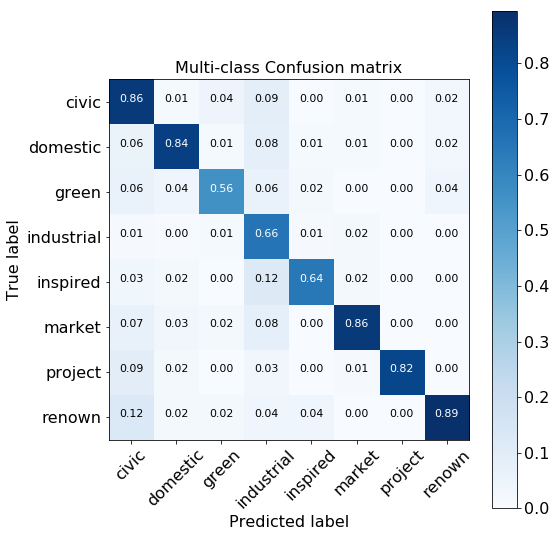

In [70]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, conv_count, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print ("In plot_confusion_matrix funct")
    print ("Confusion Matrix:")
    print (cm)
    print ("")
    print ("Sum of axis 1(was used in old version):")
    print (cm.sum(axis=1))
    
    import itertools
    if normalize:
        print ("")
        print ("Conventions:",classes )
        print ("Normalise with original convention count: ",conv_count)
        cm = cm.astype('float') / conv_count[:, np.newaxis]       
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



conv =  list (global_final_threshold.keys())
# confusion_matrix_df = global_final_results_df[(global_final_results_df['y_lbl_cnt']== 1) & (global_final_results_df['actual_lbl_cnt']==1)]
confusion_matrix_df = global_final_results_df[(global_final_results_df['actual_lbl_cnt']==1)]
print ("Number of test samples with actual cardinality = 1",confusion_matrix_df.shape[0] )

indust = confusion_matrix_df[(confusion_matrix_df['industrial']==1)&(confusion_matrix_df['industrial_y_pred']==1)]
print("TP=",indust.shape[0])
count = confusion_matrix_df[(confusion_matrix_df['y_lbl_cnt']!=0)]
print ("Number of samples with actual cardinality = 1 and predict !=0" ,count.shape[0] )

#convert the results into format to create confusion matrix
y_true_column_names = conv
y_true = confusion_matrix_df[y_true_column_names]


#to use for normalization later, calculate the sum
count_conv = y_true.sum().values
print ("Convention count", count_conv)

#replace any 1 with the column name
y_true = y_true.replace(1, pd.Series(y_true.columns, y_true.columns))


y_predict_column_names = []
for x in y_true_column_names:
    pred = x + "_y_pred"
    y_predict_column_names.append(pred)
    
y_pred = confusion_matrix_df[y_predict_column_names]

#replace any 1 with the column name
y_pred = y_pred.replace(1, pd.Series(y_pred.columns, y_pred.columns))
for x in y_true_column_names:
    y_pred = y_pred.replace({x +'_y_pred': x}, regex=True)

y_predict_list = []
y_true_list = []
#Create y-true and y-predict
for row_predict, row_true in zip(y_pred.values.tolist(),y_true.values.tolist()):
    pred = [x for x in row_predict if x != 0]
    true = [x for x in row_true if x != 0]
    if len(pred) > 0:
        #if we have more than one label in the predict then add the y true multiple times
        for x in range(len(pred)):
            y_true_list.append(true[0])
            y_predict_list.append(pred[x])


print ("label input to confusion_matrix()",conv)
multi_class_confusion_matrix = confusion_matrix(y_true_list,y_predict_list, labels=conv)

# multilabel_confusion_matrix = multilabel_confusion_matrix(y_true_list,y_predict_list, labels=conv)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(multi_class_confusion_matrix, count_conv, classes=conv,
                       title='Multi-class Confusion matrix', normalize=True)

# plot_confusion_matrix(multi_class_confusion_matrix, classes=conv,normalize=True,
#                       title='Multi-class Confusion matrix, with normalization')


print (multilabel_confusion_matrix)

In [ ]:
multilabel_confusion_matrix(y_true_list,y_predict_list, labels=conv)

In [68]:
def review_conventions (df):
    
        display (df.head(2))
        display (df['lbl_cnt'].max())
        plt.clf()
        
        for conv in _DLModels.keys():
            fig = px.bar(df, x=df['lbl_cnt'], y=df[conv], color=df[conv+'_y_pred'],height=300)
            fig.update_layout(barmode='stack', title_text=conv+' TP and FN per cardinality',yaxis={'categoryorder':'total descending'} )#stack
            fig.show()

global_final_results_df = update_predict_info(global_final_results_df)
review_conventions (global_final_results_df) 

,text,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,domestic_prob_1,green,...,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,y_lbl_cnt,actual_lbl_cnt,set_conf,lbl_cnt,pos_sample
0,!dogs.project.icberge classification.statement: drifting icebergs present threats to navigation and activities in areas such as offshore of the east coast of canada.,0,0.880597,0,0.119403,0,0.971154,0,0.028846,1,...,0.171171,0,0.951456,0,0.048544,2,1,0.443779,2,1
1,'Two Sigma Investments is another quantitative hedge fund with explosive growth that doesn’t seem to ever slow down.,0,0.973214,0,0.026786,0,1.000000,0,0.000000,0,...,0.016393,0,0.987500,0,0.012500,1,1,0.603400,1,1


3

<Figure size 432x288 with 0 Axes>

# Below is the format when Y true = 1 label and y predict is 1 label

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, conv_count, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print (cm)
    print (cm.sum(axis=1))
    import itertools
    if normalize:
        print ("Conventions:",classes )
        print ("Normalise with:",conv_count)
        
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



conv =  list (global_final_threshold.keys())
# confusion_matrix_df = global_final_results_df[(global_final_results_df['y_lbl_cnt']== 1) & (global_final_results_df['actual_lbl_cnt']==1)]
confusion_matrix_df = global_final_results_df[(global_final_results_df['actual_lbl_cnt']==1)]

display (confusion_matrix_df.head())
display (confusion_matrix_df.shape[0])
#convert the results into format to create confusion matrix
y_true_column_names = conv
# true.append("text")
y_true = confusion_matrix_df[y_true_column_names]
#replace any 1 with the column name
y_true = y_true.replace(1, pd.Series(y_true.columns, y_true.columns))

y_predict_column_names = []
for x in y_true_column_names:
    pred = x + "_y_pred"
    y_predict_column_names.append(pred)
    
y_pred = confusion_matrix_df[y_predict_column_names]
#replace any 1 with the column name
y_pred = y_pred.replace(1, pd.Series(y_pred.columns, y_pred.columns))


for x in y_true_column_names:
    y_pred = y_pred.replace({x +'_y_pred': x}, regex=True)

# display (y_true.head(5))
y_true_list = []
for row in y_true.values.tolist():
    a = [x for x in row if x != 0]
    y_true_list.append(a[0])
print ( y_true_list)


# display (y_pred.head(5))
y_predict_list = []
for row in y_pred.values.tolist():
    a = [x for x in row if x != 0]
    y_predict_list.append(a[0])
print ( y_predict_list)

    


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

multi_class_confusion_matrix = confusion_matrix(y_true_list,y_predict_list, labels=conv)

multilabel_confusion_matrix = multilabel_confusion_matrix(y_true_list,y_predict_list, labels=conv)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(multi_class_confusion_matrix, classes=conv,
                       title='Multi-class Confusion matrix, without normalization')

# plot_confusion_matrix(multi_class_confusion_matrix, classes=conv,normalize=True,
#                       title='Multi-class Confusion matrix, with normalization')


print (multilabel_confusion_matrix)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

display (global_final_results_df.head(2))

#convert the results into format to create confusion matrix
y_true_column_names = conv
# true.append("text")
y_true = global_final_results_df[y_true_column_names]

#replace any 1 with the column name
# y_true = y_true.replace(1, pd.Series(y_true.columns, y_true.columns))

y_predict_column_names = []
for x in y_true_column_names:
    pred = x + "_y_pred"
    y_predict_column_names.append(pred)
       
y_pred = global_final_results_df[y_predict_column_names]
#replace any 1 with the column name
# y_pred = y_pred.replace(1, pd.Series(y_pred.columns, y_pred.columns))


y_true_arr = np.asarray(y_true.values.tolist())

y_pred_arr = np.asarray(y_pred.values.tolist())
# print (y_true_list)
# print ("print ()")
# print (y_predict_list)
mulit_label_matrix = multilabel_confusion_matrix(y_true_arr, y_pred_arr)

In [ ]:
display (mulit_label_matrix )

In [ ]:
y_true = np.array([[1, 0, 1, 0, 0, 0, 1, 0],
                   [0, 1, 0, 1, 1, 1 ,1 ,1]])
print (y_true)
y_pred = np.array([[1, 0, 0, 0,0,0,1,1],
                    [0, 1, 0, 1, 1, 1, 1 ,1]])
multilabel_confusion_matrix(y_true, y_pred)

In [ ]:
def review_conventions (df):
    
        display (df.head(2))
        display (df['lbl_cnt'].max())
        plt.clf()
        
        for conv in _DLModels.keys():
            fig = px.bar(df, x=df['lbl_cnt'], y=df[conv], color=df[conv+'_y_pred'],height=300)
            fig.update_layout(barmode='stack', title_text=conv+' TP and FN per cardinality',yaxis={'categoryorder':'total descending'} )#stack
            fig.show()

global_final_results_df = update_predict_info(global_final_results_df)
review_conventions (global_final_results_df) 


aivm_helper.save_to_shelf('my_shelf', 'global_final_results_df', global_final_results_df, False, GIT_USR, GIT_PSWD)
aivm_helper.save_to_shelf('my_shelf', 'global_final_threshold', global_final_threshold, False, GIT_USR, GIT_PSWD)



#retrieve_shelved_object(file_name, key)

# Review some of the co-occuring sentences, set the firist var "label count" to between 2 and 8 to review co-occurances

In [ ]:
label_count = 0

print (global_final_threshold)
display (global_final_results_df.shape[0])

temp = global_final_results_df.loc[(global_final_results_df['lbl_cnt'] == label_count)]
for x in range (20):
    try:
        print ("Text to be classified:")
        display (temp.iloc[x][1])
        print ("The actual conventions:")
        for k in global_final_threshold:
            if temp.iloc[x][k] == 1:
                print (k+" actual",temp.iloc[x][k])
                print (k+" predicted",temp.iloc[x][k+"_y_pred"])
                print (k+" probability/confidence of prediction",temp.iloc[x][k+"_prob"])
        print ("")
        print ("The false positives conventions:")
        for k in global_final_threshold:
            if temp.iloc[x][k+"_y_pred"] == 1 and temp.iloc[x][k] == 0:
                #print (k+" actual",temp.iloc[x][k])
                print (k+" predicted",temp.iloc[x][k+"_y_pred"])
                print (k+" probability/confidence of prediction",temp.iloc[x][k+"_prob"])
        print ("")
        print ("The false negative conventions:")
        for k in global_final_threshold:
            if temp.iloc[x][k+"_y_pred"] == 0 and temp.iloc[x][k] == 1:
                print (k+" actual",temp.iloc[x][k])
                print (k+" predicted",temp.iloc[x][k+"_y_pred"])
                print (k+" probability/confidence of prediction",temp.iloc[x][k+"_prob"])
       
       
        print ("############") 
        print ("")
    except:
        break


# Note that at this point we have a Test DataFrame with:
- One row per unique sentence
- y_actual in column {model)
- The true/false y_predicted of each individual calibrated model in {model}_y_pred
- The probability confidence score of y_pred whether 0 or 1 in {model}_prob
- The probability confidence score of True(1) in {model}_prob_1
- The Set confidence of entire model set (in column 'set_conf'), calculated as the sum of the individual {model}_y_pred confidences. 
- The per sentence cardinality, across entire model set (in column 'lbl_cnt')

There are two types of confidence scores in BR: 
     * The confidence of an individual label prediction p(yl|x)
     * The confidence of the entire predicted set p(y|x). 

A natural requirement in many end-use applications is that the classifier provides a well-calibrated confidence (probability) to indicate the likelihood of the predicted set being correct; for example, an application may automate high-confidence predictions while manually verifying low-confidence predictions.

The individual label confidence scores has already been calibrated, with Isotonic regression.
(the established procedures are isotonic regression or Platt scaling). We should also be concerned with the set confidence calibration; as calibrating all individual label(individual model) confidence scores does not automatically calibrate the overall set prediction confidence score.

Here we will review how well calibrated the entire model set is.

In [ ]:
display(global_final_results_df.head(3))
display (global_final_threshold)

# Review the calibration of the confidence of the entire Binary Relevance Set(The probability associated with the set of predicted labels should reflect its ground truth correctness likelihood)

https://ecmlpkdd2019.org/downloads/paper/391.pdf


There are three scoring methods we can use to evaluate the predicted probabilities on your classification predictive modeling problem.

    -The log loss (or cross entropy)score that heavily penalizes predicted probabilities far away from their expected value.
    
    -The Brier score(MSE) that is gentler than log loss but still penalizes proportional to the distance from the expected value.
    
    -The area under ROC curve that summarizes the likelihood of the model predicting a higher probability for true positive cases than true negative cases.
    
 
As discussed in the above paper we will use the Brier score(MSE)

Method: 
    - 1. Calculate the set confidence per sample/sentence as the product of the individual label confidences(this is in "set_conf" column
    - 2. group about every 10 predictions with similar set confidence scores into a bucket, and plot those buckets as dots 
    -3. treating the average confidence in the group as the x-coordinate
    -4. treating the average prediction accuracy (using MSE/Brier score) in the group as the y-coordinate
    -5. we will plot also based on lable cardinality (this could be extended further to consider probability of lable combination. 
    
    


In [ ]:
#In the multilabel case with binary label indicators: , np.ones((2, 2)
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, hamming_loss

#Exact match, note [[]]
score = accuracy_score(np.array([[1, 0, 0, 0, 0, 0, 0, 0]]), np.array([[1, 1, 0, 0, 0, 0, 0, 0]]))
print (score)

#Accuracy, average over all labels
score = accuracy_score(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([1, 1, 1, 0, 1, 1, 0, 0]))
print (score)

#takes into account how wrong a prediction is in terms of probability scores.
score = brier_score_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.7, .7, .7, .3, .7, .7, .3, .3]))
print (1-score)

#takes into account how wrong a prediction is in terms of probability scores.
score = log_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.7, .7, .7, .3, .7, .7, .3, .3]))
print (1-score)


#takes into account how wrong a prediction is in terms of probability scores.
score = log_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.5, .5, 1, 1, 0, 0, 0, 0]))
print (1-score)


In [ ]:
#we need to create a new dataframe with one v
#global_pos_validation_df = global_pos_validation_df.drop(['MSE','MSE_accuracy','exact_match','accuracy','color','conf_bin','cardinality'],axis =1)
def generate_set_accuracy_scores (df, thresholds, num_conf_bins=100):
    y_actual_list = []
    y_predict_prob_list = []
    y_predict_list = []
    brier_score = []
    exact_match = []
    accuracy = []
    kl_divergance = []
    log_loss_list = []
    kullback_leibler_divergence = []
    def kl_norm(x):
        return  (2 * (  math.exp(x)/ ( math.exp(x)+1 ) ) ) - 1
       

    for conv in thresholds:
        y_actual_list.append(conv)
        y_predict_prob_list.append(conv+"_prob_1") #
        y_predict_list.append(conv+"_y_pred") 
    
    y_actual_df = df[y_actual_list]
    y_predict_prob_df = df[y_predict_prob_list]
    y_predict_df = df[y_predict_list]
    for row in range(y_actual_df.shape[0]):
        actual = []
        predict = []
        actual.append( np.array(y_actual_df.iloc[row]) )
        predict.append( np.array(y_predict_df.iloc[row]) )
        brier_score.append(brier_score_loss(y_actual_df.iloc[row] , y_predict_prob_df.iloc[row]))
        accuracy.append(accuracy_score( np.array(y_actual_df.iloc[row]), np.array(y_predict_df.iloc[row]) ))
        exact_match.append(accuracy_score( np.array(actual), np.array(predict)  ))
        log_loss_list.append(log_loss( y_actual_df.iloc[row] , y_predict_prob_df.iloc[row], normalize=True, eps = 1e-7 ))
        kullback_leibler_divergence.append(kl_norm (stats.entropy(y_actual_df.iloc[row], y_predict_prob_df.iloc[row])))
       
    df["MSE"] = brier_score
    df["MSE_accuracy"] = 1 - df["MSE"]
    df["exact_match"] = exact_match
    df["accuracy"] = accuracy
    df["log_loss"] = log_loss_list
    df["log_loss_accu"] = 1 - df["log_loss"]
    df["kl_diverge"] = kullback_leibler_divergence
    df["kl_diverge_accu"] = 1 - df["kl_diverge"]
    #assigns a color to each lbl_cnt
    colors = ['orange', 'green',  'red','pink', 'purple', 'blue', 'brown', 'black', 'yellow']
    cardinality = []
    for x in range(df.shape[0]):
        cardinality.append (df.iloc[x].lbl_cnt)
    df['cardinality'] = cardinality


    color = []
    for x in range(df.shape[0]):
        y = df.iloc[x].cardinality
        color.append(colors[int(y)]) 
    df['color'] = color
    
    df['conf_bin'] = pd.qcut(df['set_conf'], q=num_conf_bins, duplicates='drop')
    return df


def plot_reliability(df):
    plt.clf()
    colors = {0:'orange', 1:'green',  2:'red',3:'pink', 4:'purple', 5:'blue', 6:'brown', 7:'black', 8:'yellow'}
    
    #group by confidence bin for the purpose of readability/standard format for reliability curve.
    binned_mean_df = df.groupby(['conf_bin', 'lbl_cnt']).mean()
    binned_mean_df = binned_mean_df.dropna().reset_index()
    color_list = []
    for x in range(binned_mean_df.shape[0]):
        y = binned_mean_df.iloc[x].cardinality
        color_list.append(colors[int(y)])     
    binned_mean_df['color'] = color_list
    binned_mean_df = binned_mean_df[['set_conf', 'MSE', 'MSE_accuracy', 'exact_match', 'accuracy','log_loss', 'log_loss_accu', 'kl_diverge','kl_diverge_accu', 'cardinality', 'color','conf_bin']].dropna()
    ###########
    
    
    plt.figure(figsize=(30,30))
    ax1 = plt.subplot(3, 2, 1)
    ax2 = plt.subplot(3, 2, 2)
    ax3 = plt.subplot(3, 2, 3)
    ax4 = plt.subplot(3, 2, 4)
    ax5 = plt.subplot(3, 2, 5)

    def my_sub_funct (ax, df, metric, ylabel, plot_line = False):
        #force it to start at 0 to 1
        ax.set_ylim(ymin=0, ymax=1.01)
        ax.set_xlim(xmin=0, xmax=1.01)
        #removing top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #draw the "unskilled" line
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        # Add title and axis names
        ax.set_title('Reliability Diagram for Model Set')
        ax.set_xlabel('Confidence')
        ax.set_ylabel(ylabel)

        for i, dff in df.groupby("cardinality"):
            ax.scatter( dff['set_conf'], dff[metric], s=None, c=dff['color'], 
                        edgecolors='none', label="{}".format(int(i)))
            ax.legend(title = "Cardinality")
            if plot_line == True:
                ax.plot( dff['set_conf'], dff[metric], c=colors[i])
        if plot_line == True:
            handles, labels = ax.get_legend_handles_labels()
            cut_by = len(handles)/2
            ax.legend(handles[int(cut_by):], labels[int(cut_by):], title = "Cardinality")
       #######################  
    
    
    
    my_sub_funct (ax1, binned_mean_df, "accuracy", "Accuracy", plot_line = True )
    my_sub_funct (ax2, binned_mean_df, "MSE_accuracy", "1-MSE (Brier score)", plot_line = True )
    my_sub_funct (ax3, binned_mean_df, "exact_match", "Exact Match Accuracy", plot_line = True )
    my_sub_funct (ax4, binned_mean_df, "log_loss_accu", "1 - Log Loss(cross-entropy loss)", plot_line = True)
    my_sub_funct (ax5, binned_mean_df, "kl_diverge_accu", "1 - Normalised Kullback leibler divergence (relative entropy)", plot_line = True )
    
    plt.show()
    print ("https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/")
    gc.collect()
    

plot_reliability(generate_set_accuracy_scores (global_final_results_df, global_final_threshold, 10))

#In the reliability diagram note that, predictions above the diagonal are under-confident and those below the diagonal are over-confident.
Both set cardinality and prior probability are features defined on the whole
label set, rather than individual labels. Such features capture constraints and
dependencies among labels, which were not originally considered by BR. Therefore these features 
supplement BR’s own prediction score and allow the calibrator to
make better overall judgments on the predicted set. the result will basically be a beter calibrated confidence score.


Each BR set prediction is transformed to a feature vector containing: 
- Original BR confidence score: 
- set cardinality, 
- set prior probability,
- set binary representation

and the binary correctness of the prediction is used as the regression target

In [ ]:
y_actual_list = []
for conv in global_final_threshold:
        y_actual_list.append(conv)
y_actual_list.append ('set_conf')
y_actual_list.append ('cardinality')
print (y_actual_list)
to_calibrate_x = global_final_results_df[ y_actual_list ]
to_calibrate_y_actual = global_final_results_df[['exact_match']]
from sklearn.utils import shuffle
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

X, y = shuffle(to_calibrate_x, to_calibrate_y_actual, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset].copy(), y[:offset].copy()
X_test, y_test = X[offset:].copy(), y[offset:].copy()

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train['exact_match'])
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
X_test['calibrated_conf'] = list(clf.predict(X_test))
display (X_test.head())
display (y_test.head())
display (X_test.shape[0])


display(to_calibrate_x.head(2))
display(to_calibrate_y_actual.head(2))
newly_calibrated = clf.predict(to_calibrate_x)
new_df = global_final_results_df.copy()
new_df = new_df.drop('set_conf', axis =1)
new_df ['set_conf'] = list(newly_calibrated)
display (new_df.head())
plot_reliability(new_df)
del new_df

# Evaluation Metrics for over all asystem (I need to modify this)
In multi-label classification, a misclassification is no longer a hard wrong or right. 
A prediction containing a subset of the actual classes should be considered 
better than a prediction that contains none of them, i.e., predicting two 
of the three labels correctly is better than predicting no labels at all. The following metrics can be used
   * Micro-averaging & Macro-averaging (Label based measures):
   * Hamming-Loss (Example based measure):
   * Exact Match Ratio (Subset accuracy):
   * Mean column-wise ROC AUC (average of the individual AUCs of each predicted column)


In [ ]:
numbers = [dict_roc_auc[key] for key in dict_roc_auc]
mean_auc = statistics.mean(numbers)
numbers = [dict_log_loss[key] for key in dict_log_loss]
mean_log_loss = statistics.mean(numbers)
print ("* Mean column-wise ROC AUC for set of models ", mean_auc)
print ("* Mean Log Loss for set of models", mean_log_loss )
print ("")
print ("* Macro average precision", "TBD" )
print ("* Macro average recall", "TBD" )
print ("* Macro average F1", "TBD" )
micro_average_max = pd.DataFrame(threshold_best_all.iloc[threshold_best_all.shape[0]-1])
micro_average = pd.DataFrame(threshold_t_calab_all.iloc[threshold_t_calab_all.shape[0]-1])
print ("")
print ("Micro averages using T-calab with metric")
display (micro_average)
print ("")
print ("Micro averages using max value of metric")
display (micro_average_max)


# END

# Discuss with David what we need to keep below here.

In [ ]:
#AF: not sure what is the purpose of this, ie why are we training the models again?
def train_models_and_get_scores(df, t_calibration, N_executions=1):
    accs = {}
    precs = {}
    AUCs = {}
    for i in tqdm.tqdm(range(N_executions)):
    
        _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models(df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True) 

        for k in _DLModels.keys():
            model = _DLModels[k]
            x_val = _DLData_val_x[k]
            y_val = _DLData_val_y[k][:,1]

            pred = model.predict(x_val)[:,1]
            y_pred = apply_pred_threshold(pred, t_calibration)



            if k in accs:
                accs[k].append(accuracy_score(y_val, y_pred))
                precs[k].append(precision_score(y_val, y_pred))
                AUCs[k].append(roc_auc_score(y_val, y_pred))
            else:
                accs[k] = [accuracy_score(y_val, y_pred)]
                precs[k] = [precision_score(y_val, y_pred)]
                AUCs[k] = [roc_auc_score(y_val, y_pred)]
        
    return accs, precs, AUCs

#AF: not sure what is the purpose of this, ie why are we training the models again? commenting out for now:

# accs, precs, AUCs = train_models_and_get_scores(training_df, equalized_precisions_threshold)
# print("Models performance on unseen data:\n\n")
# custom_ordered_keys = ["industrial", "project", "market", "inspired", "civic", "domestic", "green", "renown"]
# for k in custom_ordered_keys:
#     avg_acc = "%.3f" % np.mean(accs[k])
#     avg_auc = "%.3f" % np.mean(AUCs[k])
#     avg_prec = "%.3f" % np.mean(precs[k])
    
#     print("{} & {}  & {} & {}\\".format(k, avg_acc, avg_prec, avg_auc))
#     print("\hline")


#this method is called once per convention with the combined responses of all used as input to
#plot the confusion matrix. The difference between this method and the AF method is that here only 
#the validation data that has true label of 1 is being used, as opposed to blindly using the data and 
#plotting a confusion matrix of the predicted_y = 1. in other words this does not consider any entry 
#in the validation set where for example convention A gives a prediction of 1 when in reality the real label is 0.
#i think this may be a bug?
def compute_confusions(conv, models_, data_x, data_y, calibration_threshold=0.656):
    global classifier_thresholds
    #create a list with  a value for each convention(initially set to 0).
    matches = [0] * len(classifier_thresholds.keys())
 
    #for convention = conv we will get a list of sentences from the validation data for ground truth label = True(1)
    sentences = data_x[conv][np.argwhere(data_y[conv][:,1]==1)]
    shape = sentences.shape
    sentences = sentences.reshape(shape[0], shape[2])
    sent_length = len(sentences)
    
    #iterate through conventions and a value between 0 and len(list "matches")
    for k, idx in zip(classifier_thresholds.keys(), range(len(matches))):
        print(sentences.shape)
        pred = models_[k].predict(sentences, verbose=0)
        pred = np.array(pred)
        matches[idx] = (pred[pred[:,1]> classifier_thresholds[k]]).sum()
    
        
    return matches, sent_length

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          class_lengths = None):
    
    #print(cm)
    if normalize:
        if class_lengths:
            cm = cm.astype('float') / np.array(class_lengths)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    print(np.sum(cm[:,1]))
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix \n Accuracy: "%.5f"' % np.mean(cm.diagonal()) 
        else:
            title = 'Confusion matrix, without normalization \n Accuracy: "%.5f"' % np.mean(cm.diagonal()) 
            
    classes = [c.capitalize() for c in classes]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_ylim(cm.shape[0]-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    
    #thresh = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    #color=cm[i,j])
                    color="white" if cm[i, j] > thresh else "black")
    
    #fig.tight_layout()
    return ax
y_true = []
y_pred = []

conf_matrix = []
class_lengths = []


for conv in classifier_thresholds.keys():
    print(" -- {}     ".format(conv))
    matches, cl_len = compute_confusions(conv, _DLModels, _DLData_val_x, _DLData_val_y)
    conf_matrix.append(matches)
    class_lengths.append(cl_len)
    
conf_matrix = np.array(conf_matrix)
class_names = list(classifier_thresholds.keys())
print (class_names)
plot_confusion_matrix(conf_matrix, class_names, normalize=True, class_lengths = class_lengths)
display(conf_matrix)

## Matches histograms

In [ ]:
def plot_matches_histogram_multiclass(_matches, _models, title=None, data_sources=[]):

    f, ax = plt.subplots(figsize=[12,6])
    
    elems = [k.replace("training_", "").replace(".txt", "").capitalize()  for k in list(_models.keys())]

    
    barWidth = 0.25  # the width of the bars
    # Set position of bar on X axis
    r1 = np.arange(len(elems))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    rs = [r1,r2,r3]


    
    for m_idx, m in enumerate(_matches):
        f = np.array(m).sum(axis=0)
        f = f / np.sum(f)
        
        print(f)
        print(r1)

        plt.bar(rs[m_idx], f, width=barWidth, edgecolor='white', label=data_sources[m_idx])
        
    # Add xticks on the middle of the group bars
    plt.xlabel('Conventions', fontweight='bold')
    plt.ylabel('Percentage', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(elems))], elems)
    plt.legend()
    plt.show()

def get_model_matches(sequences, model):
    #this is called once per model per description
    #tf.keras.preprocessing.sequence.pad_sequences
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    preds = model.predict(data)

    return preds

def count_positive_preds(preds):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>preds[j][0])
    return count

def count_positive_preds_with_threshold(preds, threshold=0.5):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>=threshold)
    return count

def calculate_matches(repositories_descriptions, _models, _tokenizers, model_preds_func=count_positive_preds, threshold=None):
    _repos_matches = []
    

    ##Â Counting number of matches per model for each repo
    for r_description in repositories_descriptions:
        #here we are generating a list of sentences
        r_description = r_description.split("\n")
        
        this_repo_matches = []
        for model_key in _models.keys():
            #now for every model, tokenize the sentence(tokenizers are the same? so no need to repeat.)
            matches=0

            tokenized_r_description = _tokenizers[model_key].texts_to_sequences(r_description)
            
            #pads the data and calls the predict function of the model in question(model_key)
            preds = get_model_matches(tokenized_r_description, _models[model_key])

            if threshold is None:
                num_matches = model_preds_func(preds)
            else:
                #call the "count_positive_preds_with_threshold" as this function was used as an input
                num_matches = model_preds_func(preds, threshold)

            this_repo_matches.append(num_matches)

        _repos_matches.append(this_repo_matches)
        
    return _repos_matches

In [ ]:
AI_repos = pd.read_csv("Data/ToBeAnalyzed/github_AI_repos_dump.csv", sep=";")
not_AI_repos = pd.read_csv("Data/ToBeAnalyzed/github_non_AI_repos_dump.csv")
display (not_AI_repos.head())
MAX_SEQUENCE_LENGTH=32


AI_texts = AI_repos['cleaned_descriptions'].values
#AI_texts =[t.split("\n") for t in AI_texts]
AI_repos_matches = calculate_matches(AI_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!


not_AI_texts = not_AI_repos['cleaned_descriptions'].values
not_AI_repos_matches = calculate_matches(not_AI_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!


S2_texts = []
with open("Data/ToBeAnalyzed/s2_random_3345_nn.txt", "rb") as f:
    S2_texts = f.readlines()
    f.close()
S2_texts = [str(s) for s in S2_texts]
    
S2_matches = calculate_matches(S2_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!

In [ ]:
data_sources = ['AI repositories', 'Not AI repositories', 'AI scientific articles']
plot_matches_histogram_multiclass([AI_repos_matches, not_AI_repos_matches, S2_matches], models[0][0], "Conventions for not AI research articles", data_sources)
print(len(AI_repos))
print(len(not_AI_repos))okay
ai_sents = []
for t in AI_repos['cleaned_descriptions'].values:
    for term in t.split("\n"):
        ai_sents.append(str(term))
display(len(ai_sents))


not_ai_sents = []
for t in not_AI_repos['cleaned_descriptions'].values:
    for term in t.split("\n"):
        not_ai_sents.append(str(term))
display (len(not_ai_sents))

display (AI_repos['repo_num_stars'].hist(bins=50))
display(np.mean(AI_repos['repo_num_stars']))
display(np.mean(not_AI_repos['repo_num_stars']))
display(np.max(AI_repos['repo_num_stars']))
display(np.mean(AI_repos['repo_num_stars']))
display(AI_repos.head())
display(AI_repos['repo_language'].mode())
display(not_AI_repos['repo_language'].mode())
display(len(AI_repos[AI_repos['repo_language'] == 'Python']) / len(AI_repos))
display(len(not_AI_repos[not_AI_repos['repo_language'] == 'JavaScript']) / len(not_AI_repos))

In [ ]:
training_df[training_df['convention'] == 'inspired']

In [ ]:
for c in training_df['convention'].unique():
    print(c)
    print(len(training_df[training_df['convention'] == c]))
    print()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(epochs=20):
    word_index = extended_tokenizer.word_index
    num_epochs = epochs
    EMBEDDING_DIM=100
    MAX_SEQUENCE_LENGTH=32
    
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)


    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#

    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)

    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model
    
model = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)

In [ ]:
np.linspace(.1, 1.0, 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
training_df['convention'].unique()

In [ ]:
for _conv in training_df['convention'].unique():
    tmp_df_train = training_df[training_df['convention']==_conv]

    texts = tmp_df_train['text'].values
    labels = tmp_df_train['label'].values

    sequences = extended_tokenizer.texts_to_sequences(texts)


    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))

    X=data
    y=labels

    title = "Learning Curves ({})".format(_conv.capitalize())
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    estimator = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

    plt.show()

In [ ]:
data_portions = np.arange(.1, 1.01, 0.10)
print(data_portions)

accs = []

for p in data_portions:
    
    tmp_df_train = training_df[training_df['convention']=='industrial']

    texts = tmp_df_train['text'].values
    labels = tmp_df_train['label'].values

    sequences = extended_tokenizer.texts_to_sequences(texts)


    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))
    
    selected_indexes = random.choice(list(enumerate(X)))[0]
    
    tmp_x = data[selected_indexes]
    tmp_y = labels[selected_indexes]
    
    
    
    
    

    title = "Learning Curves (Industrial)"
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    #cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    estimator = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    
    
    estimator.train(tmp_x)

    
    accs.append(metrics.accuracy_score())